<a href="https://colab.research.google.com/github/marcinwolter/AI_Lublin_2023/blob/main/dcgan_overriding_train_step.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DCGAN to generate face images

**Author:** [fchollet](https://twitter.com/fchollet)<br>
**Date created:** 2019/04/29<br>
**Last modified:** 2021/01/01<br>
**Description:** A simple DCGAN trained using `fit()` by overriding `train_step` on CelebA images.

with small modifications from M. Wolter

## Setup

In [1]:
#! pip install gdown

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import os
import gdown
from zipfile import ZipFile

## Prepare CelebA data

The home page of CelebA dataset: http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html

We'll use face images from the CelebA dataset, resized to 64x64.

In [3]:

! rm -fr celeba_gan
! rm -f generated_img_*.jpg
os.makedirs("celeba_gan")

url = "https://drive.google.com/uc?id=1O7m1010EJjLE5QxLZiM9Fpjs7Oj6e684"
output = "celeba_gan/data.zip"
gdown.download(url, output, quiet=True)

with ZipFile("celeba_gan/data.zip", "r") as zipobj:
    zipobj.extractall("celeba_gan")


Create a dataset from our folder, reduce the size to 32x32 pixels and rescale the images to the [0-1] range:

In [ ]:
dataset = keras.utils.image_dataset_from_directory(
    "celeba_gan/align_celeba", label_mode=None, image_size=(32, 32), batch_size=32
)
dataset = dataset.map(lambda x: x / 255.0)


Found 99999 files belonging to 1 classes.


Let's display a sample image:

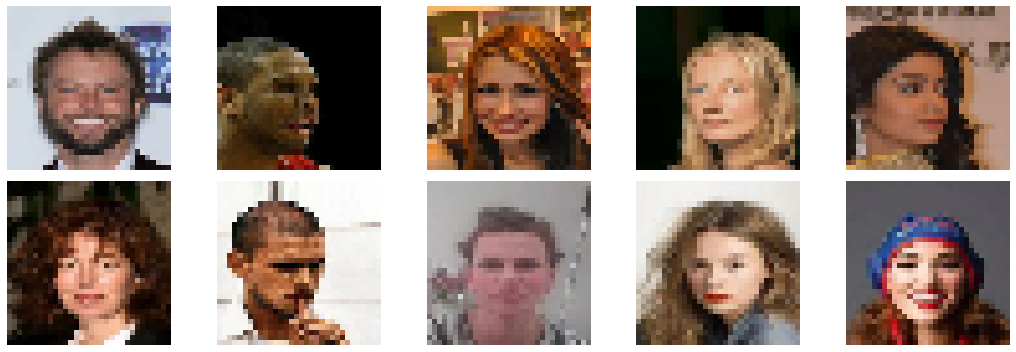

In [ ]:

plt.figure(figsize=(15,5))
i=0
for x in dataset:
        plt.subplot(2, 5, i+1)
        plt.imshow((x.numpy() * 255).astype("int32")[0])
        plt.axis('off')
        i=i+1
        if i>9:
            break

plt.tight_layout()
plt.show()



## Create the discriminator

It maps a 64x64 image to a binary classification score.

In [ ]:
discriminator = keras.Sequential(
    [
        keras.Input(shape=(32, 32, 3)),
        layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Flatten(),
        layers.Dropout(0.2),
        layers.Dense(1, activation="sigmoid"),
    ],
    name="discriminator",
)
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 16, 16, 64)        3136      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 16, 16, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 128)         131200    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 128)         262272    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 4, 4, 128)         0         
                                                                 
 flatten (Flatten)           (None, 2048)            

## Create the generator

It mirrors the discriminator, replacing `Conv2D` layers with `Conv2DTranspose` layers.

In [ ]:
latent_dim = 128

generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        layers.Dense(8 * 8 * 128),
        layers.Reshape((8, 8, 128)),
        layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        #layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
        #layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(3, kernel_size=5, padding="same", activation="sigmoid"),
    ],
    name="generator",
)
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 8192)              1056768   
                                                                 
 reshape (Reshape)           (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 16, 16, 128)      262272    
 nspose)                                                         
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 32, 32, 256)      524544    
 ranspose)                                                       
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 32, 32, 256)       0 

## Override `train_step`

In [ ]:

class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Decode them to fake images
        generated_images = self.generator(random_latent_vectors)

        # Combine them with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # Assemble labels discriminating real from fake images
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
        # Add random noise to the labels - important trick!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Assemble labels that say "all real images"
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }


## Create a callback that periodically saves and displays generated images

In [ ]:

class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = keras.preprocessing.image.array_to_img(generated_images[i])
            img.save("generated_img_%03d_%d.png" % (epoch, i))


        plt.figure(figsize=(15,5))

        for i in range(self.num_img):
            img = keras.preprocessing.image.array_to_img(generated_images[i])
            plt.subplot(2, 5, i+1)
            plt.imshow(img)
            plt.axis('off')
        plt.tight_layout()
        plt.show()


## Train the end-to-end model

Epoch 1/100
3125/3125 [==============================] - ETA: 0s - d_loss: 0.5436 - g_loss: 1.3363

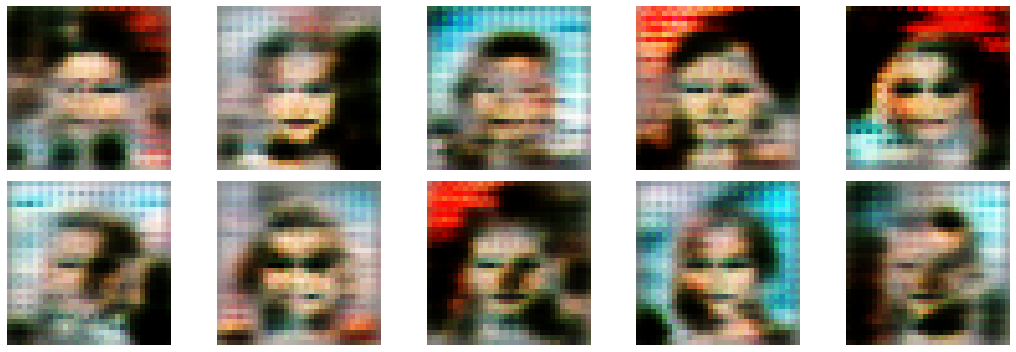

3125/3125 [==============================] - 145s 44ms/step - d_loss: 0.5436 - g_loss: 1.3363
Epoch 2/100
3125/3125 [==============================] - ETA: 0s - d_loss: 0.6263 - g_loss: 1.0379

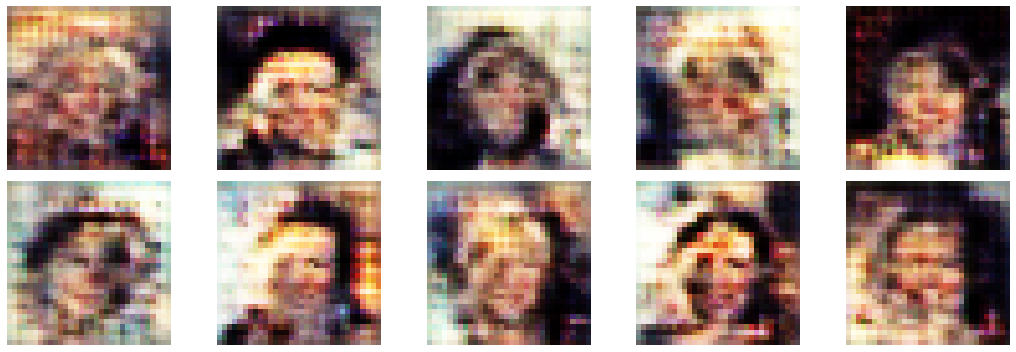

3125/3125 [==============================] - 137s 44ms/step - d_loss: 0.6263 - g_loss: 1.0379
Epoch 3/100
3124/3125 [============================>.] - ETA: 0s - d_loss: 0.6444 - g_loss: 0.9960

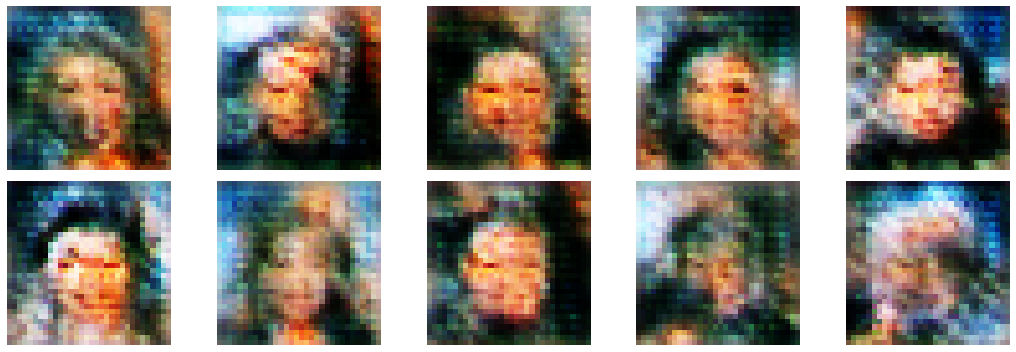

3125/3125 [==============================] - 139s 44ms/step - d_loss: 0.6444 - g_loss: 0.9961
Epoch 4/100
3124/3125 [============================>.] - ETA: 0s - d_loss: 0.6608 - g_loss: 0.9032

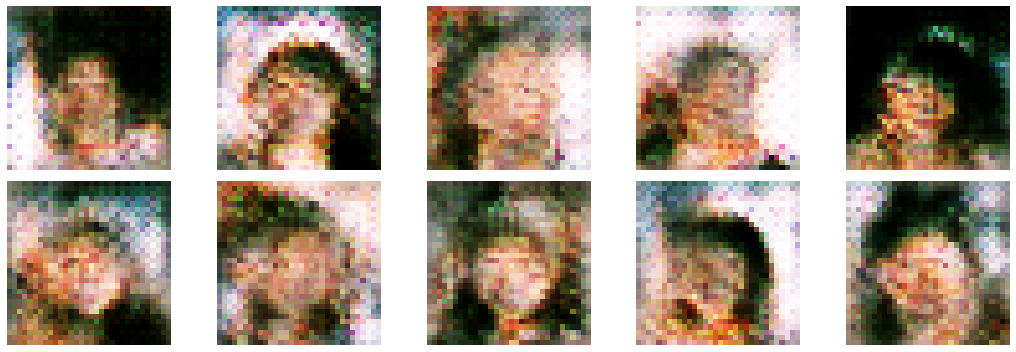

3125/3125 [==============================] - 108s 34ms/step - d_loss: 0.6607 - g_loss: 0.9032
Epoch 5/100
3124/3125 [============================>.] - ETA: 0s - d_loss: 0.6758 - g_loss: 0.9040

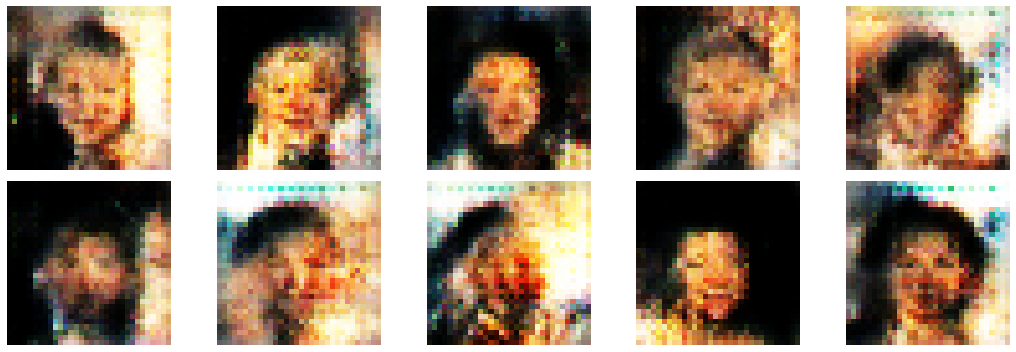

3125/3125 [==============================] - 157s 50ms/step - d_loss: 0.6758 - g_loss: 0.9040
Epoch 6/100
3125/3125 [==============================] - ETA: 0s - d_loss: 0.6625 - g_loss: 0.9072

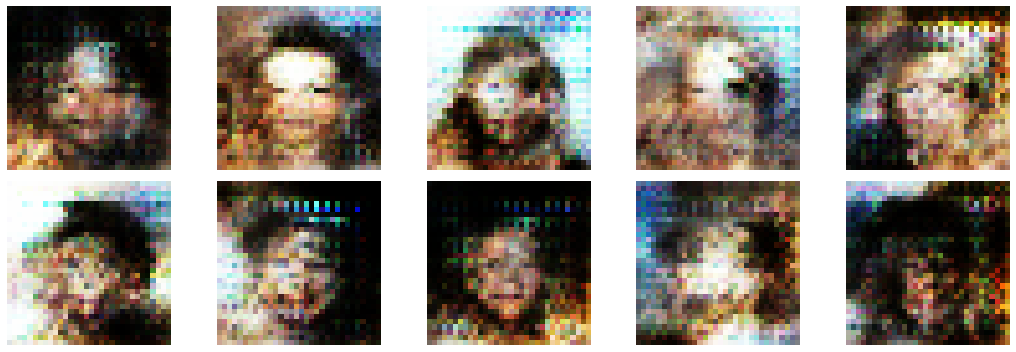

3125/3125 [==============================] - 149s 47ms/step - d_loss: 0.6625 - g_loss: 0.9072
Epoch 7/100
3124/3125 [============================>.] - ETA: 0s - d_loss: 0.6669 - g_loss: 0.9045

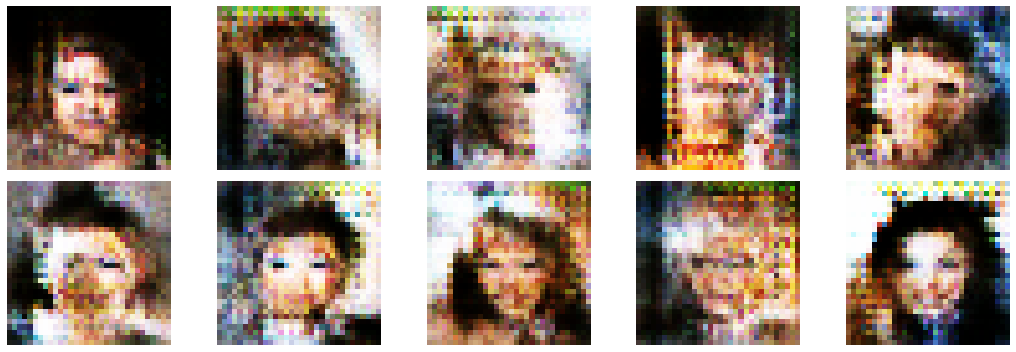

3125/3125 [==============================] - 157s 50ms/step - d_loss: 0.6669 - g_loss: 0.9044
Epoch 8/100
3124/3125 [============================>.] - ETA: 0s - d_loss: 0.6632 - g_loss: 0.9180

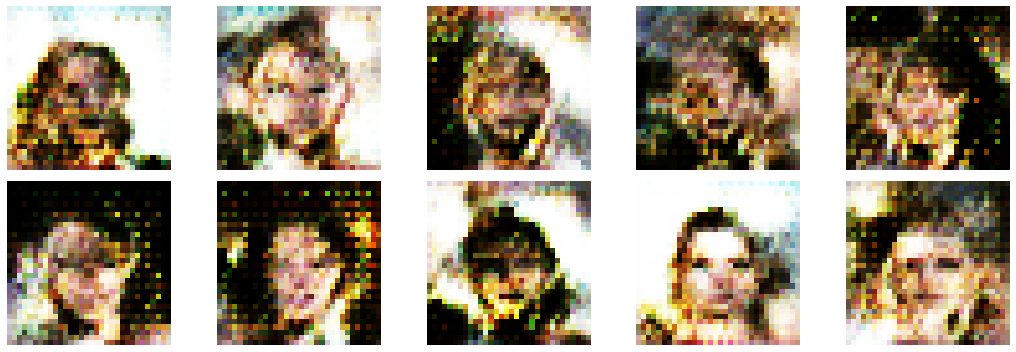

3125/3125 [==============================] - 100s 32ms/step - d_loss: 0.6631 - g_loss: 0.9181
Epoch 9/100
3125/3125 [==============================] - ETA: 0s - d_loss: 0.6492 - g_loss: 0.9430

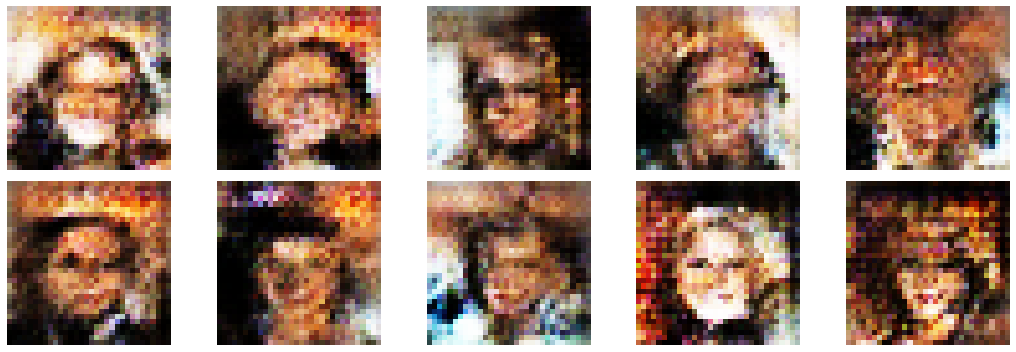

3125/3125 [==============================] - 160s 51ms/step - d_loss: 0.6492 - g_loss: 0.9430
Epoch 10/100
3125/3125 [==============================] - ETA: 0s - d_loss: 0.6277 - g_loss: 1.0046

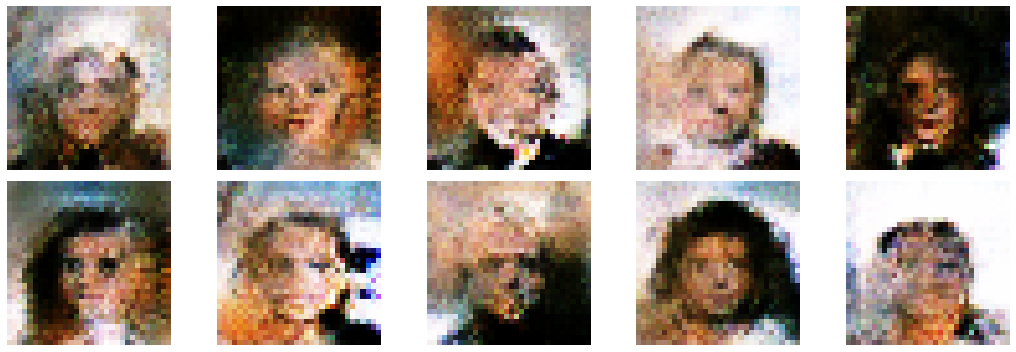

3125/3125 [==============================] - 102s 33ms/step - d_loss: 0.6277 - g_loss: 1.0046
Epoch 11/100
3125/3125 [==============================] - ETA: 0s - d_loss: 0.6439 - g_loss: 0.9589

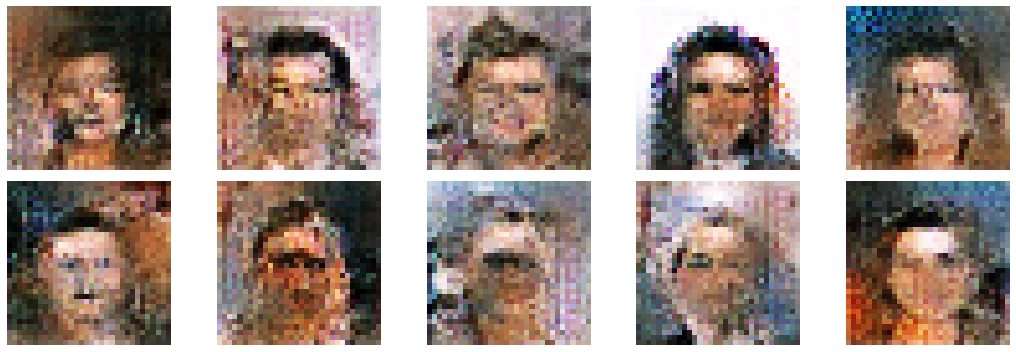

3125/3125 [==============================] - 194s 62ms/step - d_loss: 0.6439 - g_loss: 0.9589
Epoch 12/100
3124/3125 [============================>.] - ETA: 0s - d_loss: 0.6438 - g_loss: 0.9188

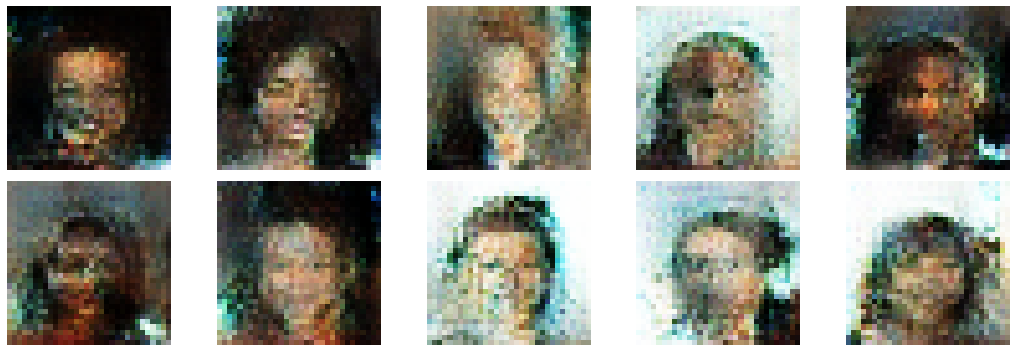

3125/3125 [==============================] - 121s 39ms/step - d_loss: 0.6438 - g_loss: 0.9187
Epoch 13/100
3125/3125 [==============================] - ETA: 0s - d_loss: 0.6431 - g_loss: 0.9379

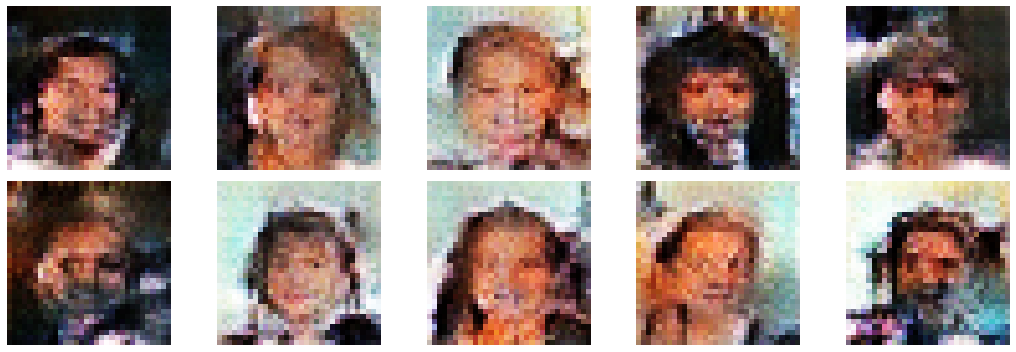

3125/3125 [==============================] - 157s 50ms/step - d_loss: 0.6431 - g_loss: 0.9379
Epoch 14/100
3124/3125 [============================>.] - ETA: 0s - d_loss: 0.6436 - g_loss: 0.9120

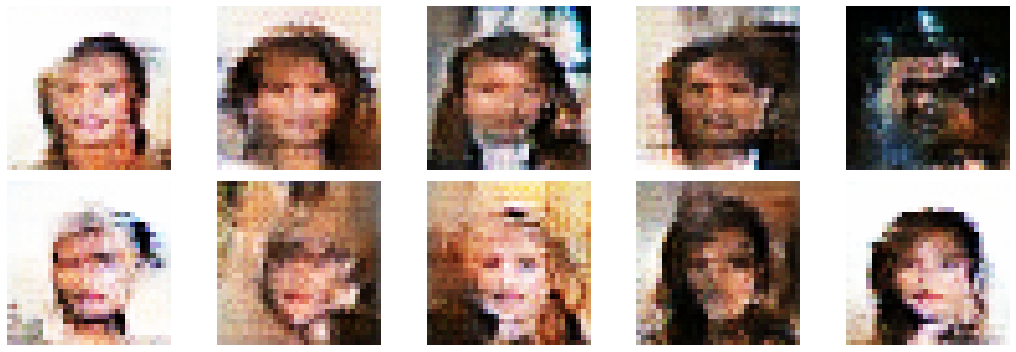

3125/3125 [==============================] - 149s 48ms/step - d_loss: 0.6436 - g_loss: 0.9120
Epoch 15/100
3124/3125 [============================>.] - ETA: 0s - d_loss: 0.6435 - g_loss: 0.9163

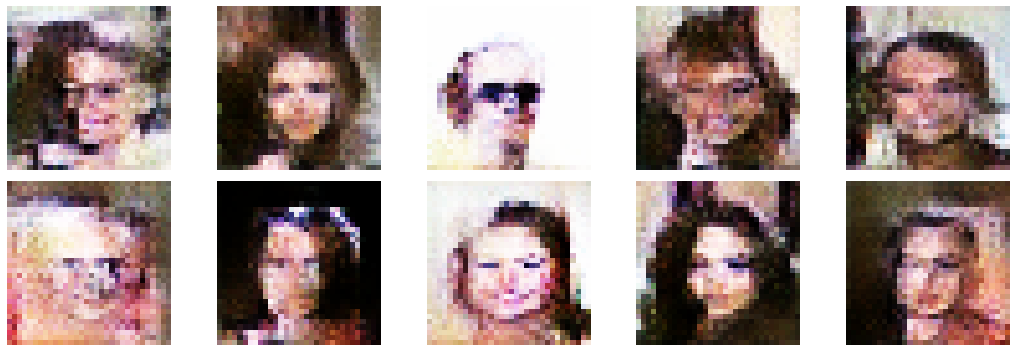

3125/3125 [==============================] - 151s 48ms/step - d_loss: 0.6435 - g_loss: 0.9162
Epoch 16/100
3125/3125 [==============================] - ETA: 0s - d_loss: 0.6477 - g_loss: 0.8940

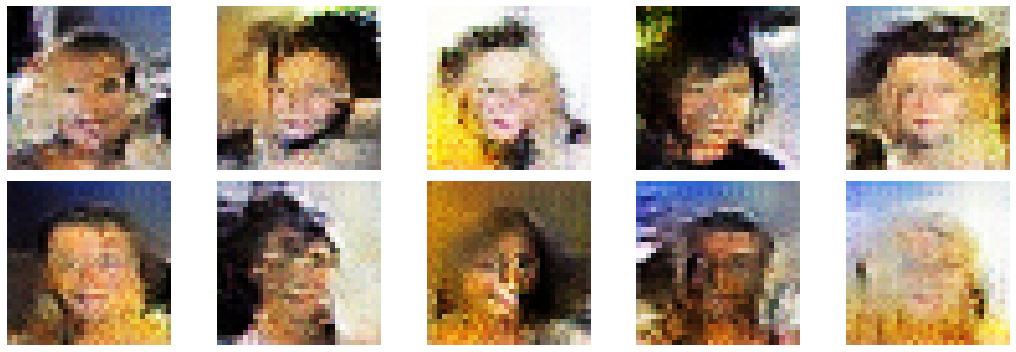

3125/3125 [==============================] - 133s 42ms/step - d_loss: 0.6477 - g_loss: 0.8940
Epoch 17/100
3124/3125 [============================>.] - ETA: 0s - d_loss: 0.6533 - g_loss: 0.8838

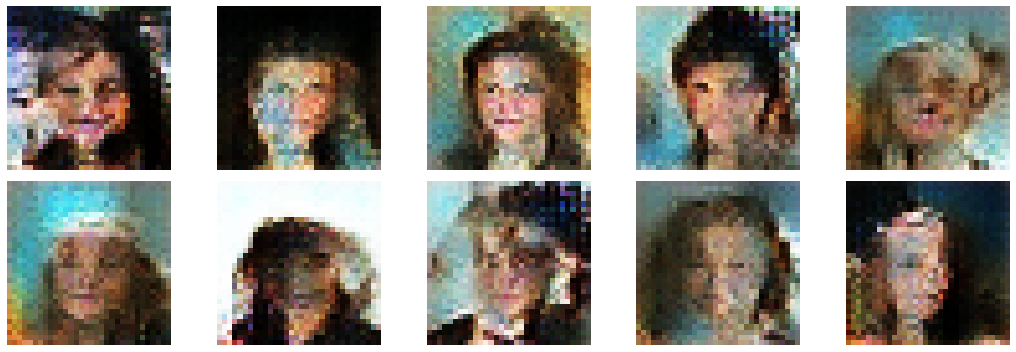

3125/3125 [==============================] - 182s 58ms/step - d_loss: 0.6533 - g_loss: 0.8838
Epoch 18/100
3124/3125 [============================>.] - ETA: 0s - d_loss: 0.6435 - g_loss: 0.8927

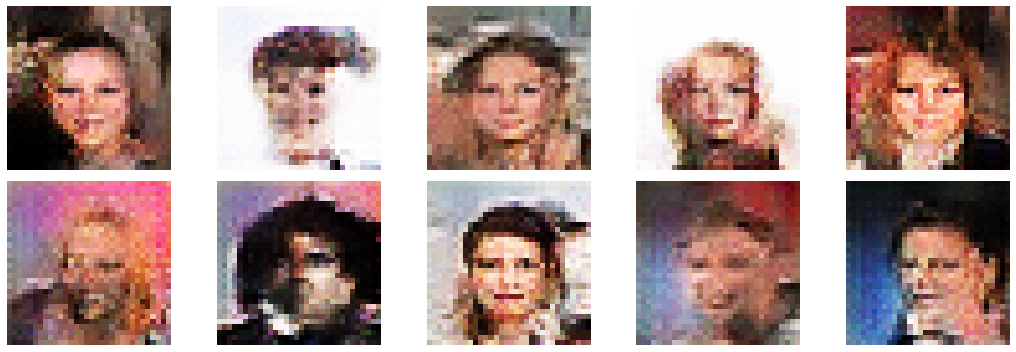

3125/3125 [==============================] - 159s 51ms/step - d_loss: 0.6435 - g_loss: 0.8927
Epoch 19/100
3125/3125 [==============================] - ETA: 0s - d_loss: 0.6470 - g_loss: 0.8918

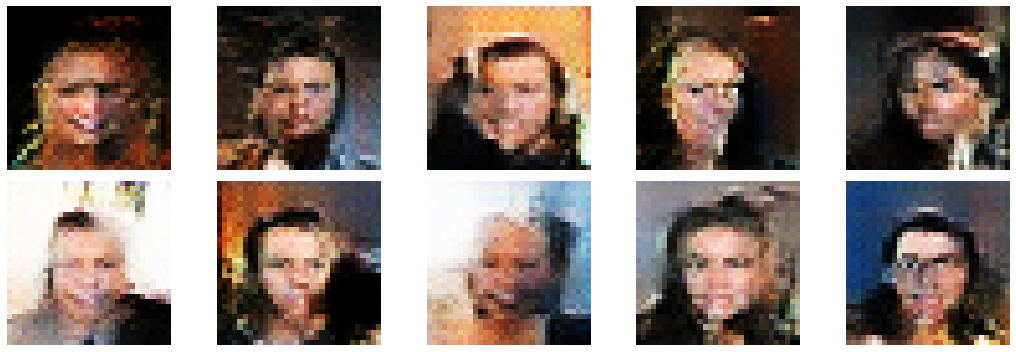

3125/3125 [==============================] - 151s 48ms/step - d_loss: 0.6470 - g_loss: 0.8918
Epoch 20/100
3125/3125 [==============================] - ETA: 0s - d_loss: 0.6511 - g_loss: 0.8766

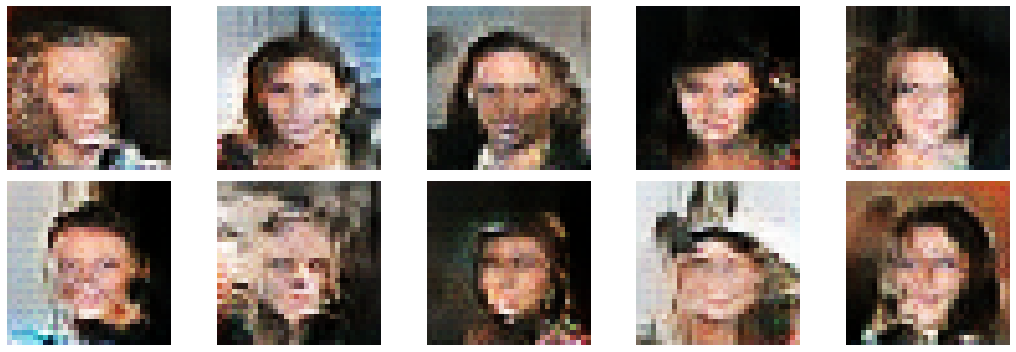

3125/3125 [==============================] - 163s 52ms/step - d_loss: 0.6511 - g_loss: 0.8766
Epoch 21/100
3125/3125 [==============================] - ETA: 0s - d_loss: 0.6460 - g_loss: 0.8782

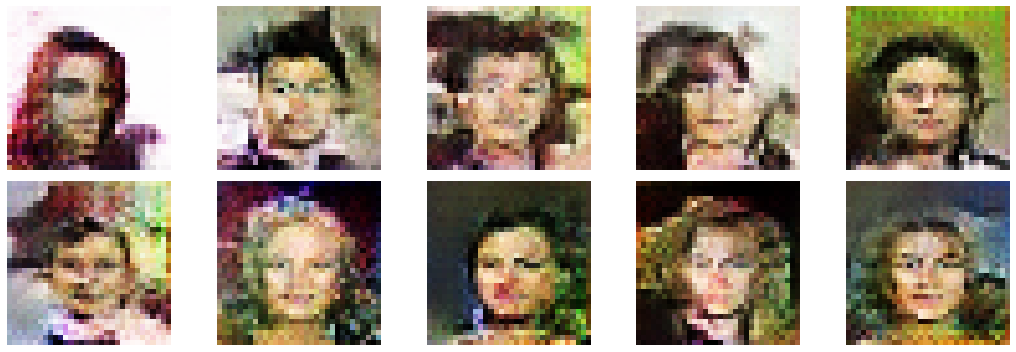

3125/3125 [==============================] - 120s 38ms/step - d_loss: 0.6460 - g_loss: 0.8782
Epoch 22/100
3125/3125 [==============================] - ETA: 0s - d_loss: 0.6482 - g_loss: 0.8751

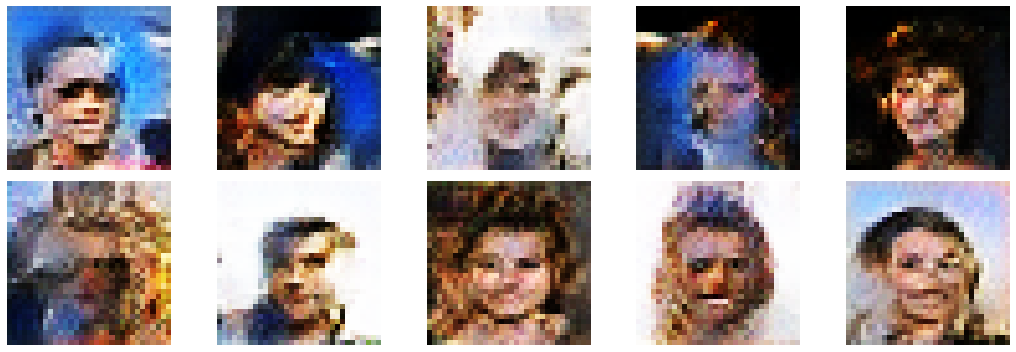

3125/3125 [==============================] - 183s 59ms/step - d_loss: 0.6482 - g_loss: 0.8751
Epoch 23/100
3124/3125 [============================>.] - ETA: 0s - d_loss: 0.6443 - g_loss: 0.8838

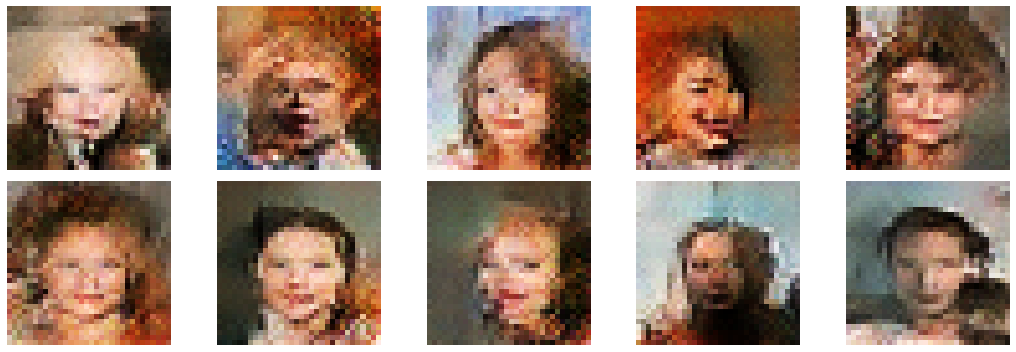

3125/3125 [==============================] - 130s 41ms/step - d_loss: 0.6443 - g_loss: 0.8838
Epoch 24/100
3124/3125 [============================>.] - ETA: 0s - d_loss: 0.6438 - g_loss: 0.8784

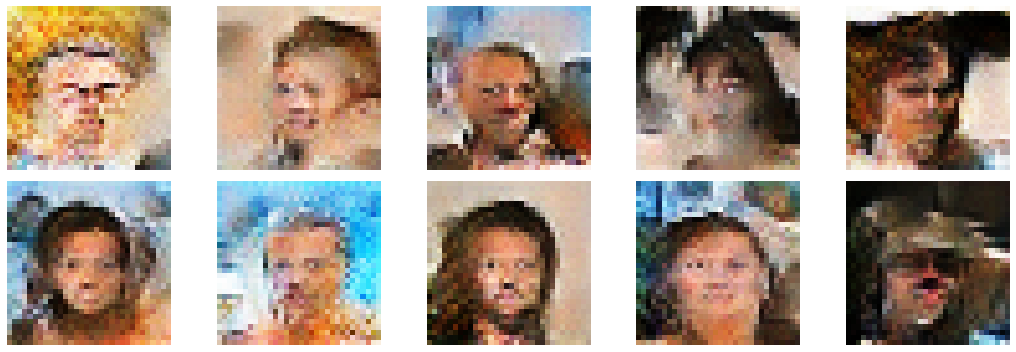

3125/3125 [==============================] - 155s 49ms/step - d_loss: 0.6438 - g_loss: 0.8784
Epoch 26/100
3125/3125 [==============================] - ETA: 0s - d_loss: 0.6436 - g_loss: 0.8757

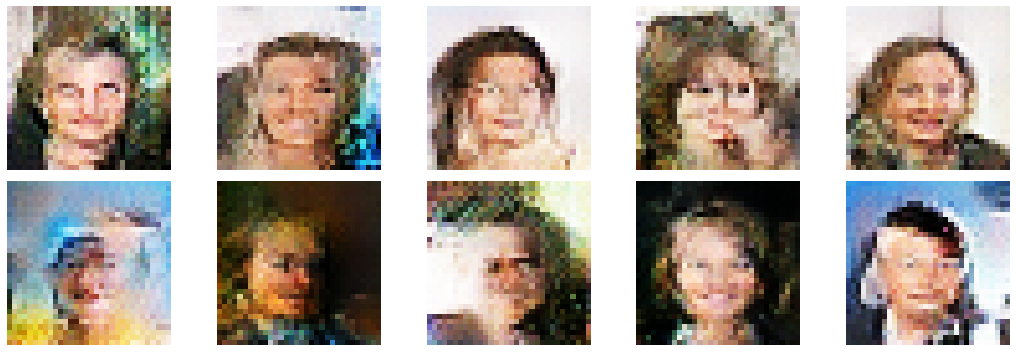

3125/3125 [==============================] - 157s 50ms/step - d_loss: 0.6436 - g_loss: 0.8757
Epoch 27/100
1087/3125 [=========>....................] - ETA: 1:03 - d_loss: 0.6449 - g_loss: 0.8848

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3124/3125 [============================>.] - ETA: 0s - d_loss: 0.6439 - g_loss: 0.8801

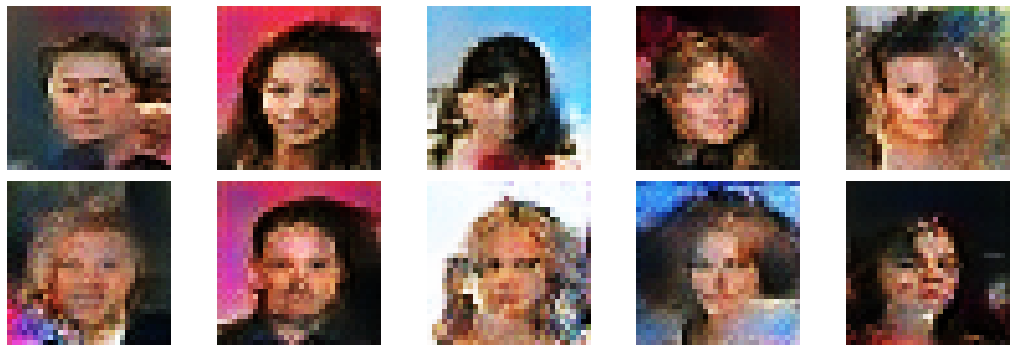

3125/3125 [==============================] - 167s 53ms/step - d_loss: 0.6439 - g_loss: 0.8801
Epoch 29/100
3124/3125 [============================>.] - ETA: 0s - d_loss: 0.6409 - g_loss: 0.8914

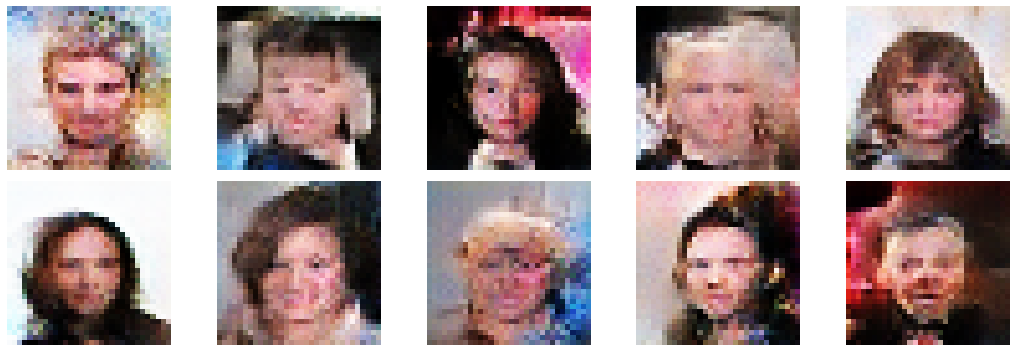

3125/3125 [==============================] - 123s 39ms/step - d_loss: 0.6409 - g_loss: 0.8915
Epoch 30/100
1689/3125 [===============>..............] - ETA: 44s - d_loss: 0.6427 - g_loss: 0.8793

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3124/3125 [============================>.] - ETA: 0s - d_loss: 0.6422 - g_loss: 0.8787

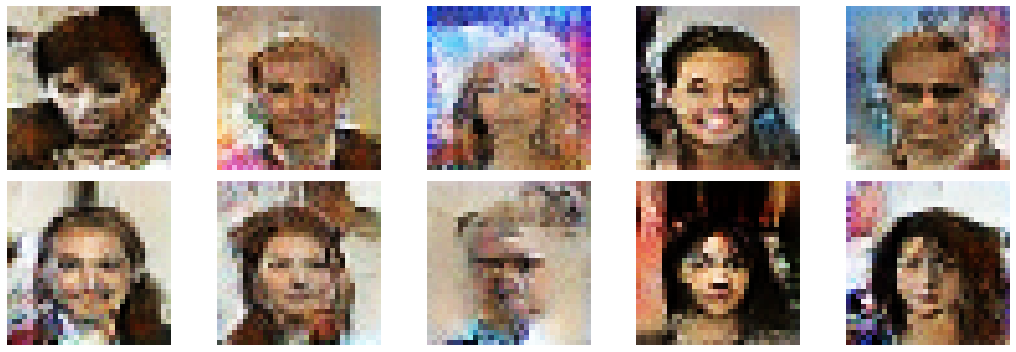

3125/3125 [==============================] - 152s 49ms/step - d_loss: 0.6423 - g_loss: 0.8786
Epoch 32/100
3125/3125 [==============================] - ETA: 0s - d_loss: 0.6426 - g_loss: 0.8790

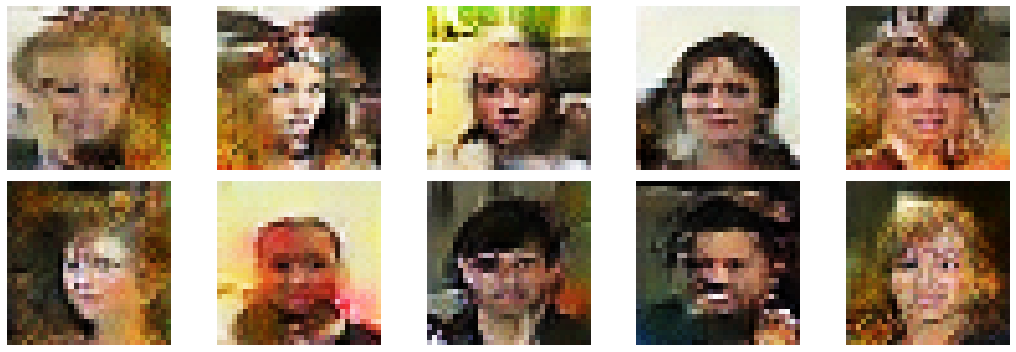

3125/3125 [==============================] - 126s 40ms/step - d_loss: 0.6426 - g_loss: 0.8790
Epoch 33/100
3125/3125 [==============================] - ETA: 0s - d_loss: 0.6429 - g_loss: 0.8789

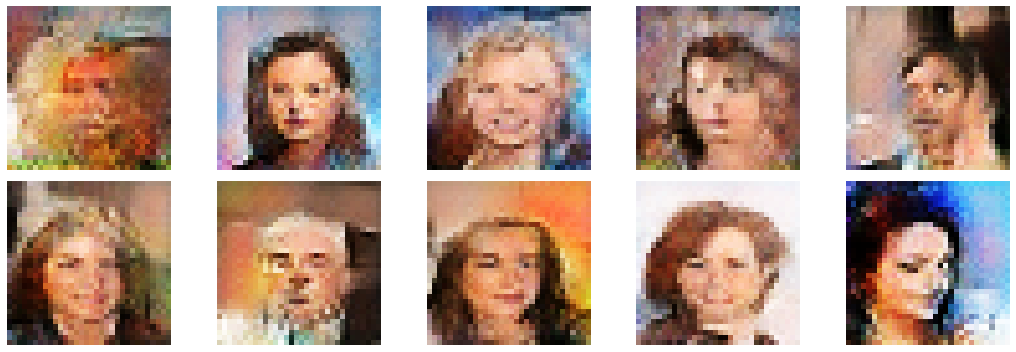

3125/3125 [==============================] - 175s 56ms/step - d_loss: 0.6429 - g_loss: 0.8789
Epoch 34/100
 879/3125 [=======>......................] - ETA: 1:10 - d_loss: 0.6434 - g_loss: 0.8785

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3125/3125 [==============================] - ETA: 0s - d_loss: 0.6403 - g_loss: 0.8941

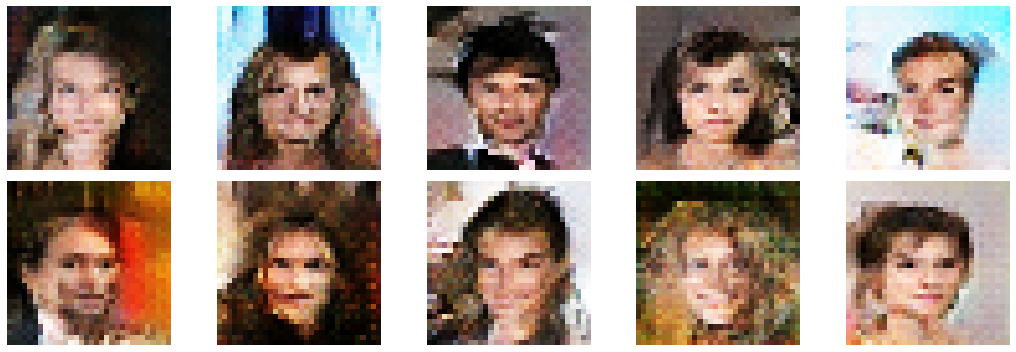

3125/3125 [==============================] - 145s 46ms/step - d_loss: 0.6403 - g_loss: 0.8941
Epoch 35/100
3125/3125 [==============================] - ETA: 0s - d_loss: 0.6396 - g_loss: 0.8839

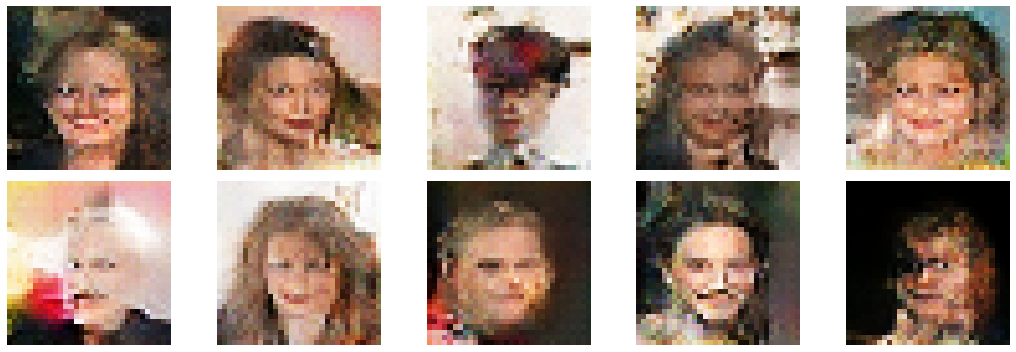

3125/3125 [==============================] - 122s 39ms/step - d_loss: 0.6396 - g_loss: 0.8839
Epoch 36/100
3125/3125 [==============================] - ETA: 0s - d_loss: 0.6380 - g_loss: 0.8938

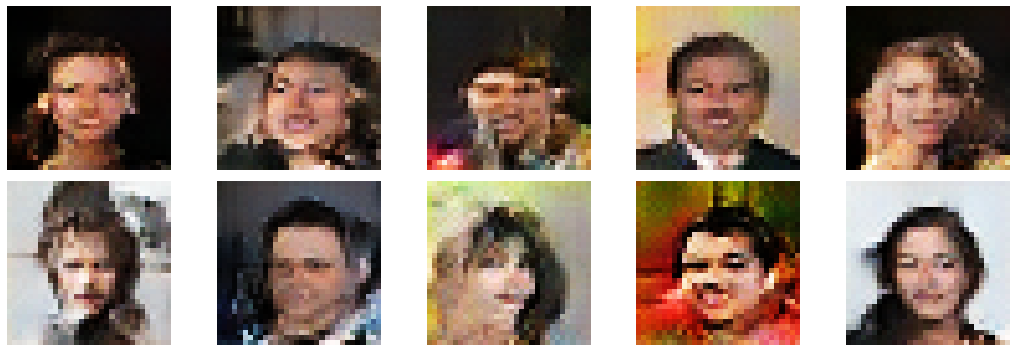

3125/3125 [==============================] - 99s 31ms/step - d_loss: 0.6380 - g_loss: 0.8938
Epoch 37/100
1885/3125 [=================>............] - ETA: 1:19 - d_loss: 0.6388 - g_loss: 0.8868

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3124/3125 [============================>.] - ETA: 0s - d_loss: 0.6373 - g_loss: 0.8897

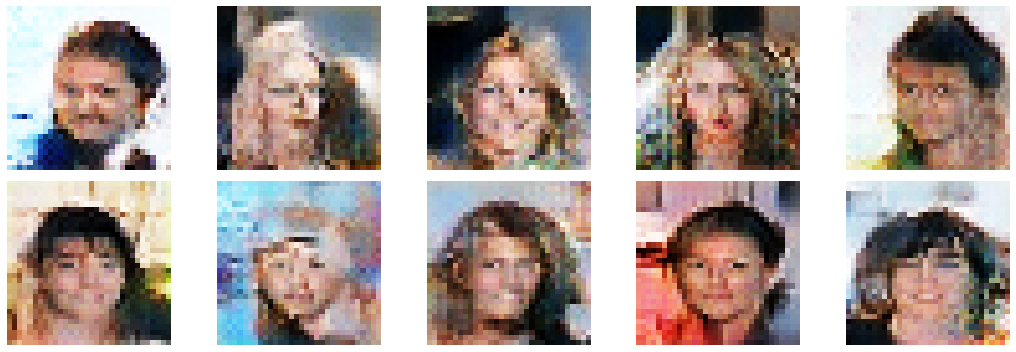

3125/3125 [==============================] - 150s 48ms/step - d_loss: 0.6373 - g_loss: 0.8897
Epoch 39/100
2961/3125 [===========================>..] - ETA: 7s - d_loss: 0.6380 - g_loss: 0.8887

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3124/3125 [============================>.] - ETA: 0s - d_loss: 0.6342 - g_loss: 0.8988

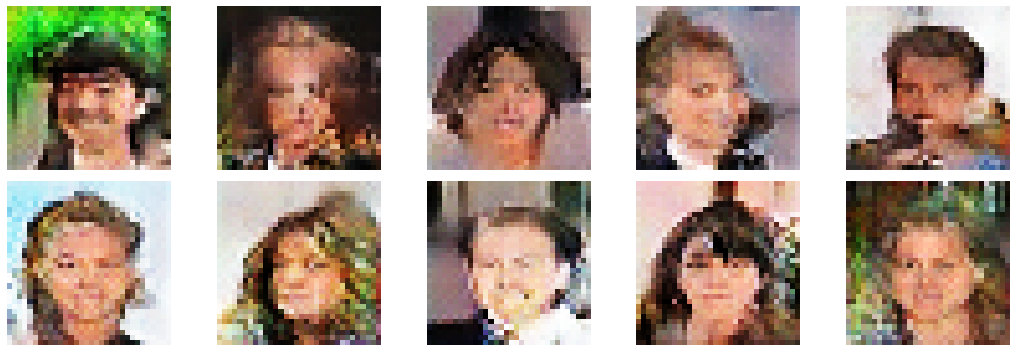

3125/3125 [==============================] - 98s 31ms/step - d_loss: 0.6342 - g_loss: 0.8989
Epoch 41/100
3125/3125 [==============================] - ETA: 0s - d_loss: 0.6332 - g_loss: 0.8959

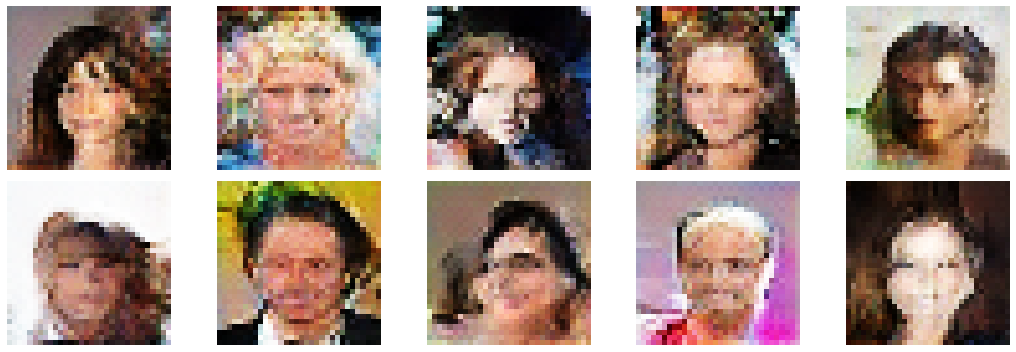

3125/3125 [==============================] - 163s 52ms/step - d_loss: 0.6332 - g_loss: 0.8959
Epoch 42/100
1964/3125 [=================>............] - ETA: 42s - d_loss: 0.6322 - g_loss: 0.9002

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3125/3125 [==============================] - ETA: 0s - d_loss: 0.6329 - g_loss: 0.9242

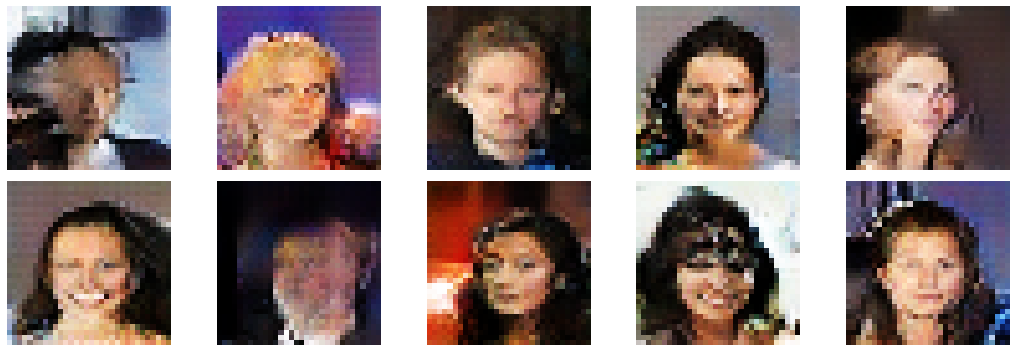

3125/3125 [==============================] - 174s 56ms/step - d_loss: 0.6329 - g_loss: 0.9242
Epoch 44/100
3125/3125 [==============================] - ETA: 0s - d_loss: 0.6315 - g_loss: 0.9002

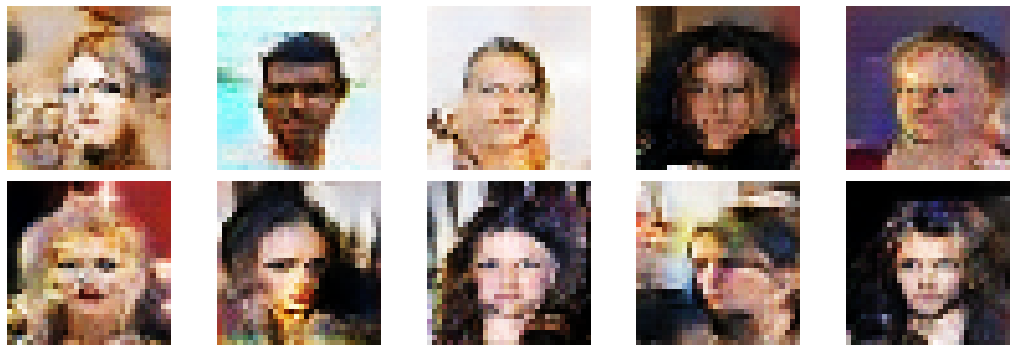

3125/3125 [==============================] - 150s 48ms/step - d_loss: 0.6315 - g_loss: 0.9002
Epoch 45/100
3124/3125 [============================>.] - ETA: 0s - d_loss: 0.6272 - g_loss: 0.9177

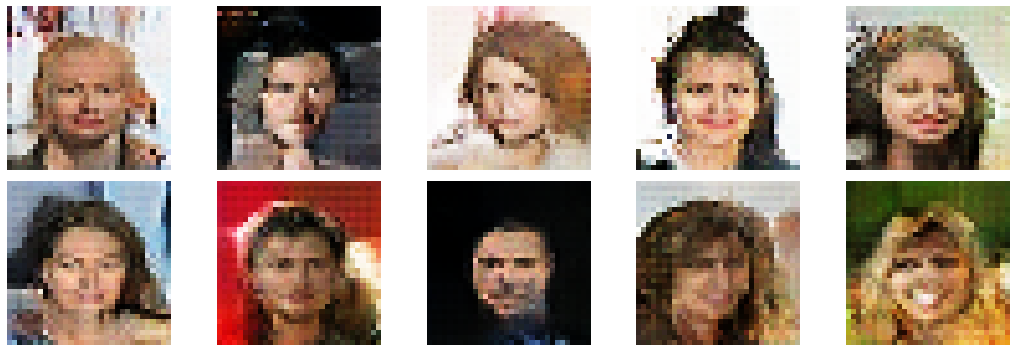

3125/3125 [==============================] - 113s 36ms/step - d_loss: 0.6272 - g_loss: 0.9178
Epoch 46/100
 857/3125 [=======>......................] - ETA: 2:43 - d_loss: 0.6314 - g_loss: 0.9013

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3125/3125 [==============================] - ETA: 0s - d_loss: 0.6267 - g_loss: 0.9180

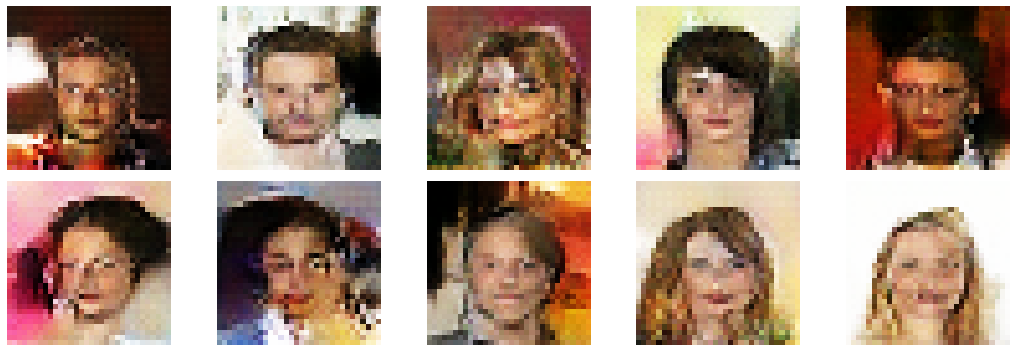

3125/3125 [==============================] - 115s 37ms/step - d_loss: 0.6267 - g_loss: 0.9180
Epoch 48/100
2731/3125 [=========================>....] - ETA: 23s - d_loss: 0.6278 - g_loss: 0.9184

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3125/3125 [==============================] - ETA: 0s - d_loss: 0.6241 - g_loss: 0.9172

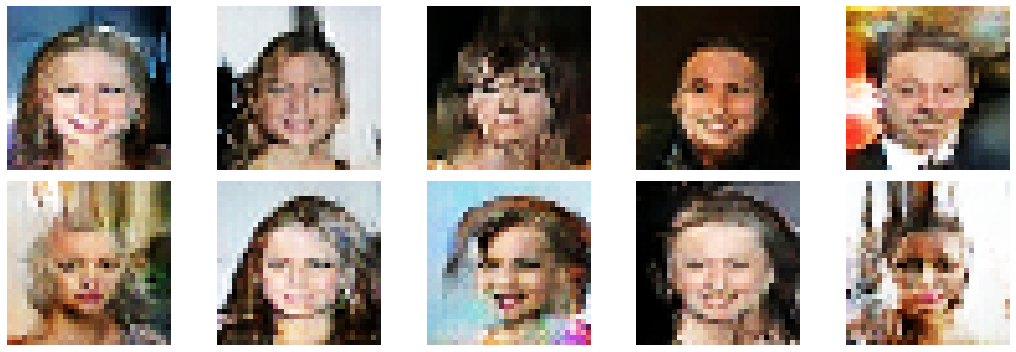

3125/3125 [==============================] - 137s 44ms/step - d_loss: 0.6241 - g_loss: 0.9172
Epoch 50/100
3124/3125 [============================>.] - ETA: 0s - d_loss: 0.6234 - g_loss: 0.9299

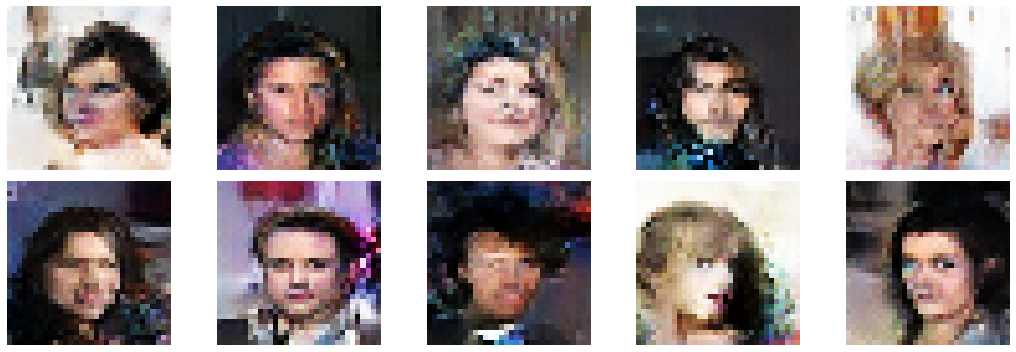

3125/3125 [==============================] - 156s 50ms/step - d_loss: 0.6234 - g_loss: 0.9298
Epoch 51/100
1921/3125 [=================>............] - ETA: 59s - d_loss: 0.6226 - g_loss: 0.9330

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3125/3125 [==============================] - ETA: 0s - d_loss: 0.6220 - g_loss: 0.9225

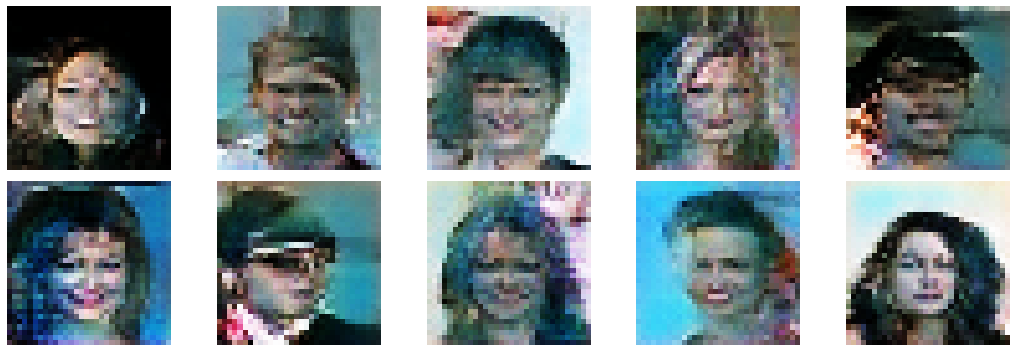

3125/3125 [==============================] - 99s 32ms/step - d_loss: 0.6220 - g_loss: 0.9225
Epoch 53/100
3125/3125 [==============================] - ETA: 0s - d_loss: 0.6190 - g_loss: 0.9408

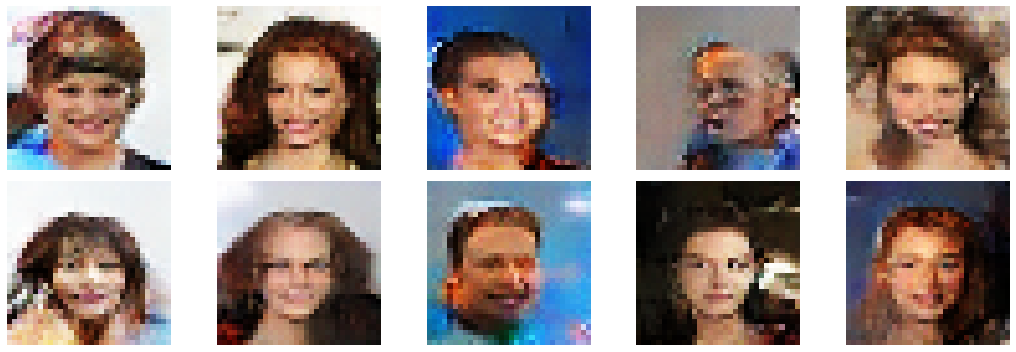

3125/3125 [==============================] - 198s 63ms/step - d_loss: 0.6190 - g_loss: 0.9408
Epoch 54/100
3124/3125 [============================>.] - ETA: 0s - d_loss: 0.6192 - g_loss: 0.9347

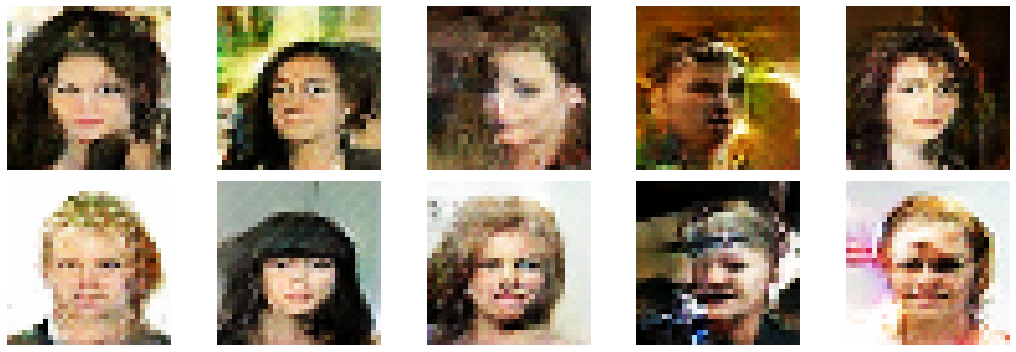

3125/3125 [==============================] - 116s 37ms/step - d_loss: 0.6192 - g_loss: 0.9347
Epoch 55/100
2301/3125 [=====================>........] - ETA: 25s - d_loss: 0.6162 - g_loss: 0.9434

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3124/3125 [============================>.] - ETA: 0s - d_loss: 0.6137 - g_loss: 0.9518

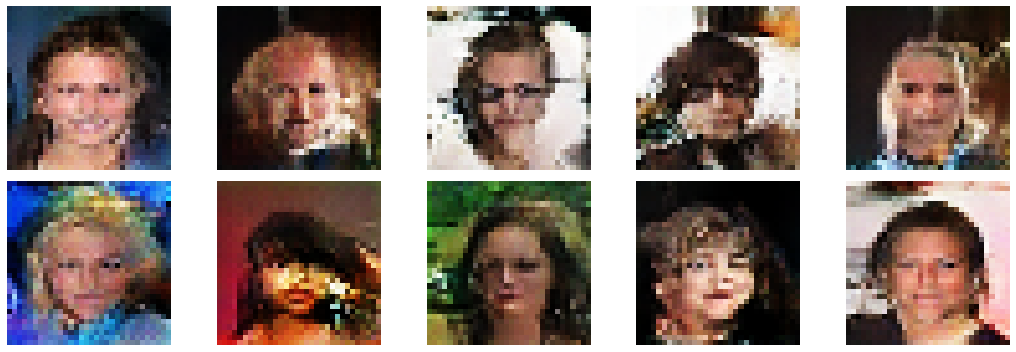

3125/3125 [==============================] - 143s 46ms/step - d_loss: 0.6137 - g_loss: 0.9518
Epoch 57/100
3125/3125 [==============================] - ETA: 0s - d_loss: 0.6160 - g_loss: 0.9429

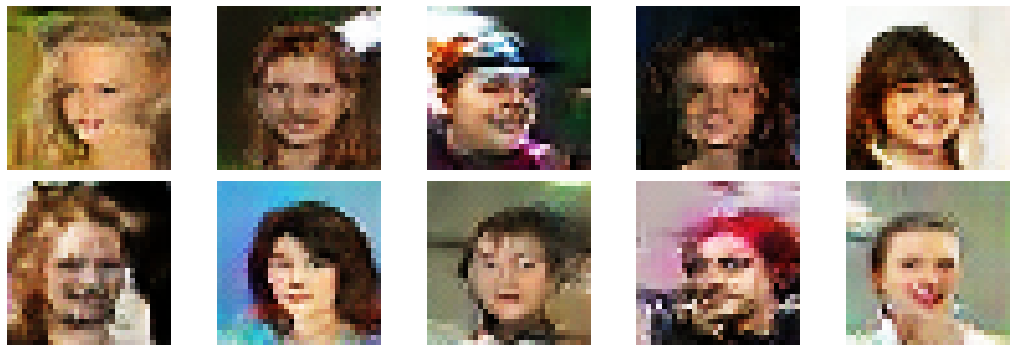

3125/3125 [==============================] - 109s 35ms/step - d_loss: 0.6160 - g_loss: 0.9429
Epoch 58/100
1418/3125 [============>.................] - ETA: 1:31 - d_loss: 0.6161 - g_loss: 0.9388

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3124/3125 [============================>.] - ETA: 0s - d_loss: 0.6099 - g_loss: 0.9486

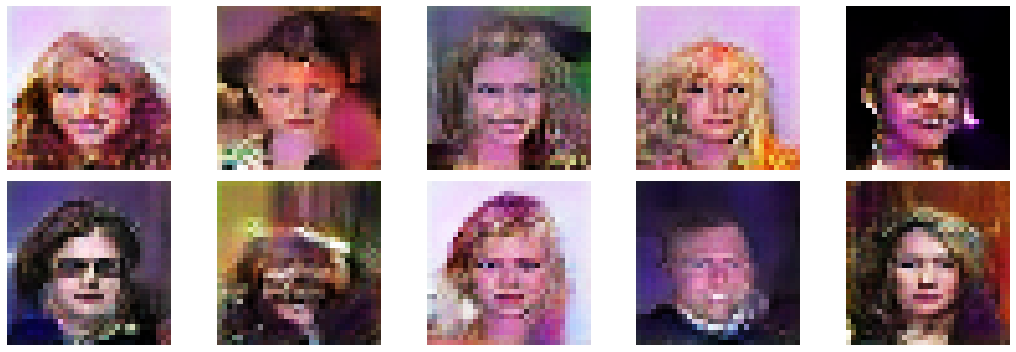

3125/3125 [==============================] - 132s 42ms/step - d_loss: 0.6099 - g_loss: 0.9487
Epoch 61/100
3125/3125 [==============================] - ETA: 0s - d_loss: 0.6071 - g_loss: 0.9666

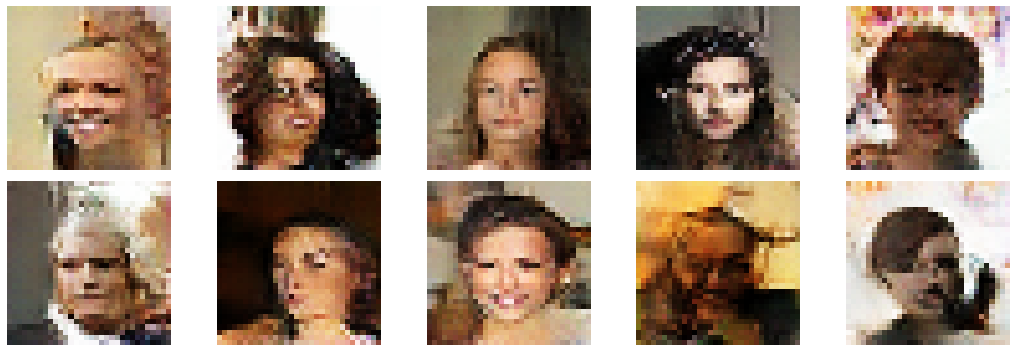

3125/3125 [==============================] - 99s 32ms/step - d_loss: 0.6071 - g_loss: 0.9666
Epoch 62/100
 718/3125 [=====>........................] - ETA: 1:15 - d_loss: 0.6084 - g_loss: 0.9596

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3125/3125 [==============================] - ETA: 0s - d_loss: 0.6065 - g_loss: 0.9627

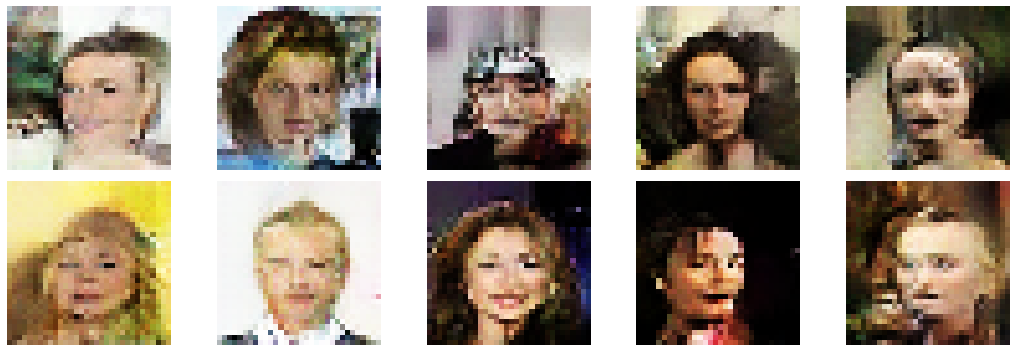

3125/3125 [==============================] - 167s 53ms/step - d_loss: 0.6065 - g_loss: 0.9627
Epoch 63/100
3125/3125 [==============================] - ETA: 0s - d_loss: 0.6057 - g_loss: 0.9679

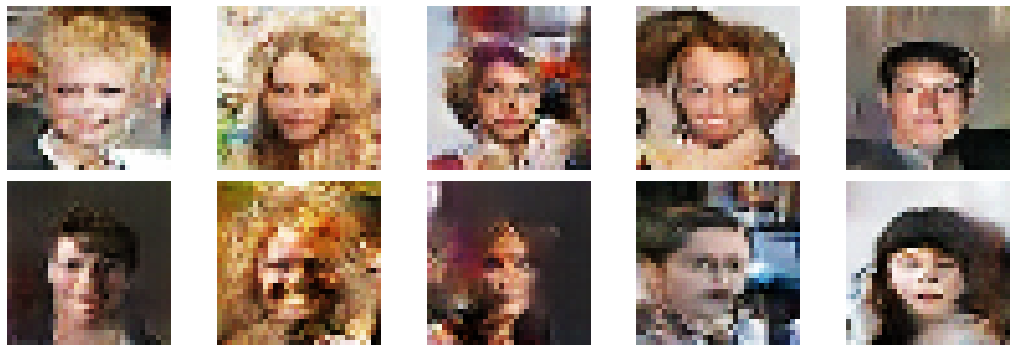

3125/3125 [==============================] - 151s 48ms/step - d_loss: 0.6057 - g_loss: 0.9679
Epoch 64/100
1989/3125 [==================>...........] - ETA: 58s - d_loss: 0.6046 - g_loss: 0.9680

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3124/3125 [============================>.] - ETA: 0s - d_loss: 0.6028 - g_loss: 0.9793

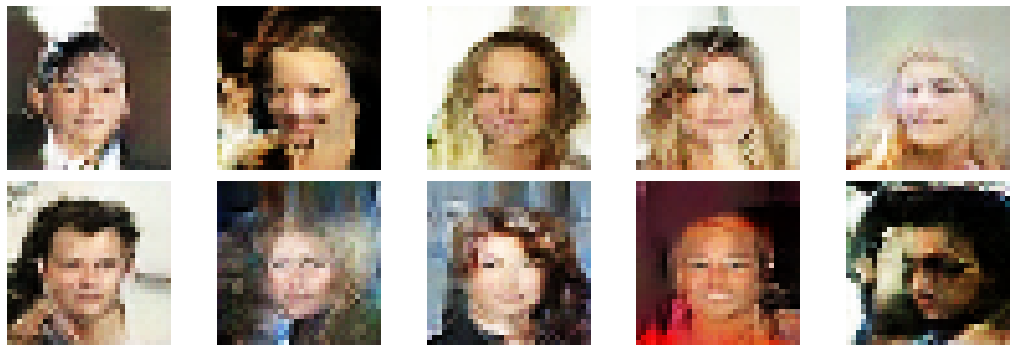

3125/3125 [==============================] - 98s 31ms/step - d_loss: 0.6028 - g_loss: 0.9794
Epoch 66/100
3125/3125 [==============================] - ETA: 0s - d_loss: 0.6036 - g_loss: 0.9711

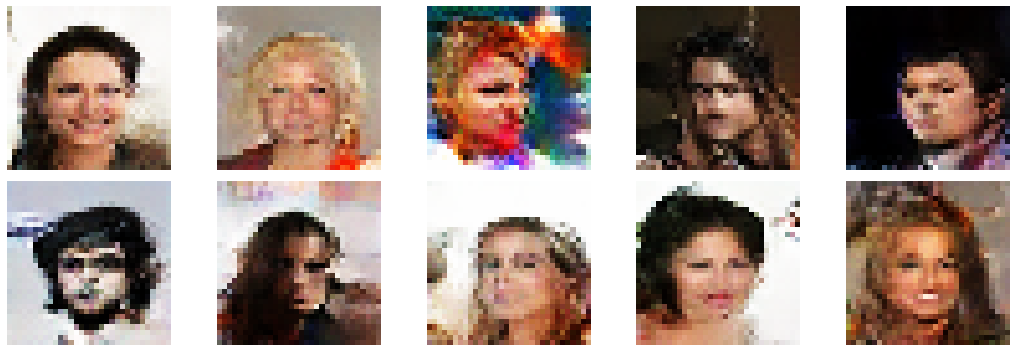

3125/3125 [==============================] - 173s 55ms/step - d_loss: 0.6036 - g_loss: 0.9711
Epoch 67/100
3125/3125 [==============================] - ETA: 0s - d_loss: 0.6021 - g_loss: 0.9787

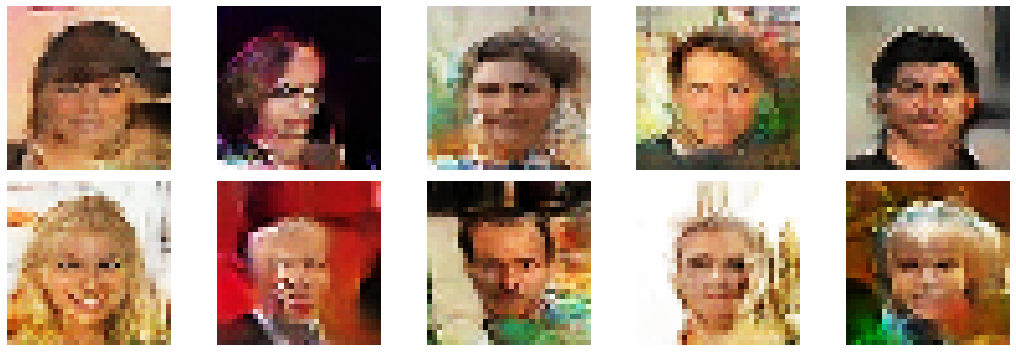

3125/3125 [==============================] - 114s 36ms/step - d_loss: 0.6021 - g_loss: 0.9787
Epoch 68/100
 841/3125 [=======>......................] - ETA: 1:11 - d_loss: 0.5995 - g_loss: 0.9735

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3125/3125 [==============================] - ETA: 0s - d_loss: 0.5973 - g_loss: 0.9919

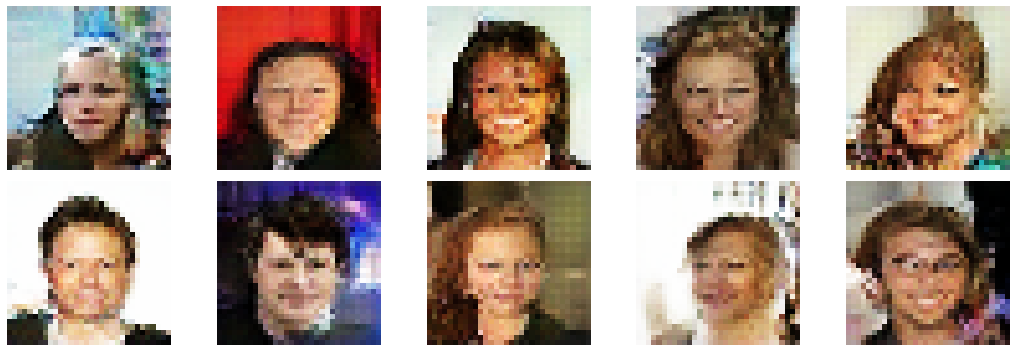

3125/3125 [==============================] - 122s 39ms/step - d_loss: 0.5973 - g_loss: 0.9919
Epoch 70/100
3124/3125 [============================>.] - ETA: 0s - d_loss: 0.5952 - g_loss: 0.9940

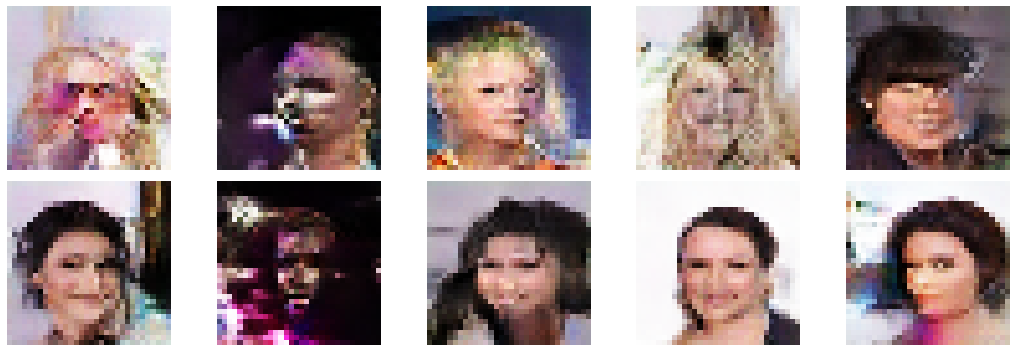

3125/3125 [==============================] - 119s 38ms/step - d_loss: 0.5952 - g_loss: 0.9939
Epoch 71/100
   1/3125 [..............................] - ETA: 12:09 - d_loss: 0.6503 - g_loss: 1.0088

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3124/3125 [============================>.] - ETA: 0s - d_loss: 0.5945 - g_loss: 0.9993

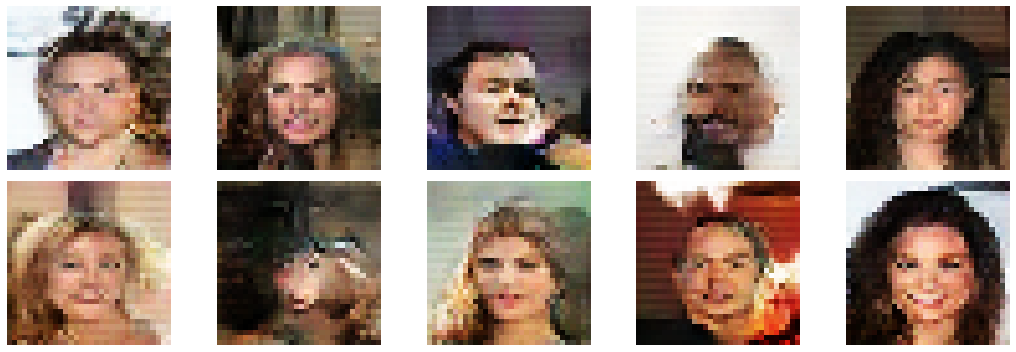

3125/3125 [==============================] - 161s 51ms/step - d_loss: 0.5945 - g_loss: 0.9993
Epoch 72/100
3125/3125 [==============================] - ETA: 0s - d_loss: 0.5941 - g_loss: 0.9953

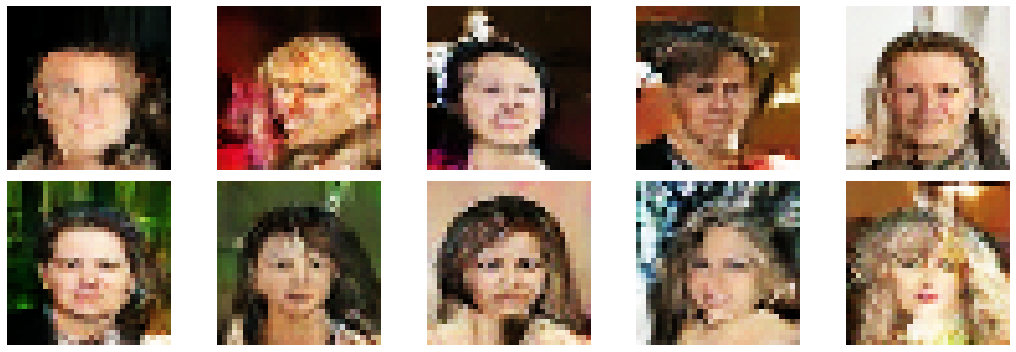

3125/3125 [==============================] - 163s 52ms/step - d_loss: 0.5941 - g_loss: 0.9953
Epoch 73/100
1757/3125 [===============>..............] - ETA: 1:13 - d_loss: 0.5913 - g_loss: 1.0087

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3124/3125 [============================>.] - ETA: 0s - d_loss: 0.5915 - g_loss: 0.9987

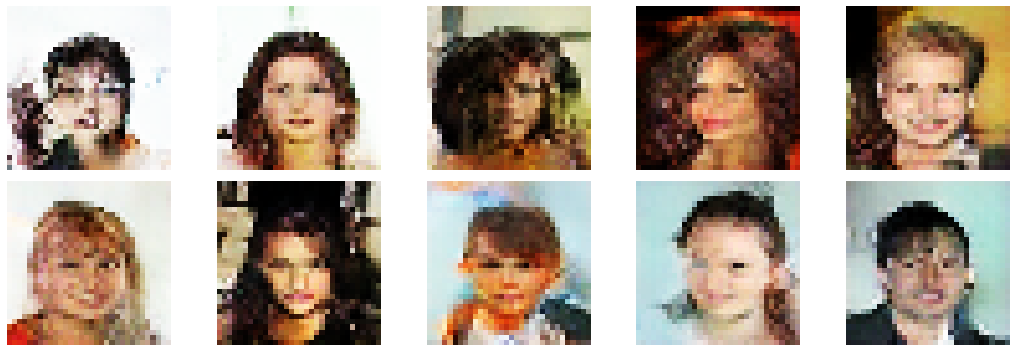

3125/3125 [==============================] - 123s 39ms/step - d_loss: 0.5915 - g_loss: 0.9986
Epoch 75/100
3124/3125 [============================>.] - ETA: 0s - d_loss: 0.5896 - g_loss: 1.0115

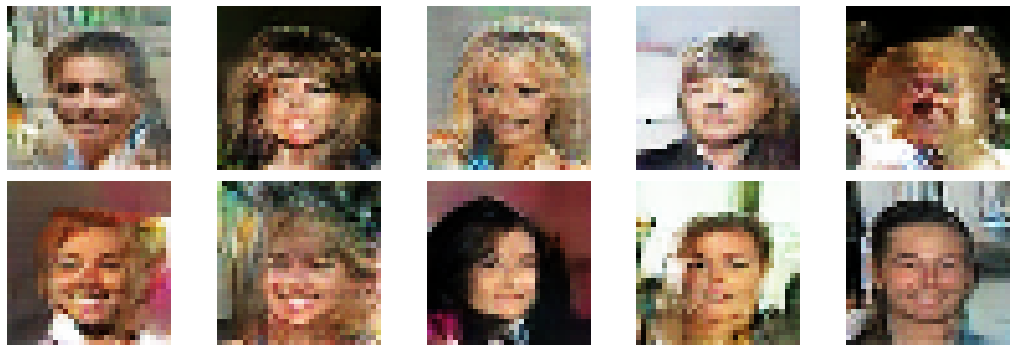

3125/3125 [==============================] - 151s 48ms/step - d_loss: 0.5896 - g_loss: 1.0115
Epoch 76/100
3124/3125 [============================>.] - ETA: 0s - d_loss: 0.5850 - g_loss: 1.0307

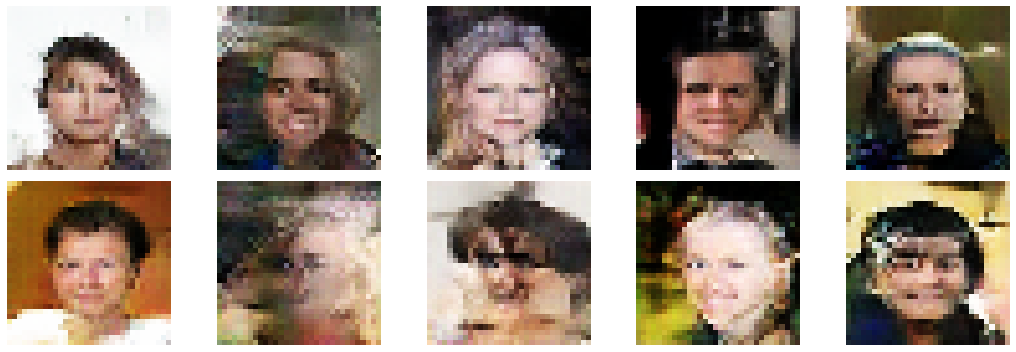

3125/3125 [==============================] - 124s 40ms/step - d_loss: 0.5850 - g_loss: 1.0307
Epoch 77/100
3124/3125 [============================>.] - ETA: 0s - d_loss: 0.5869 - g_loss: 1.0205

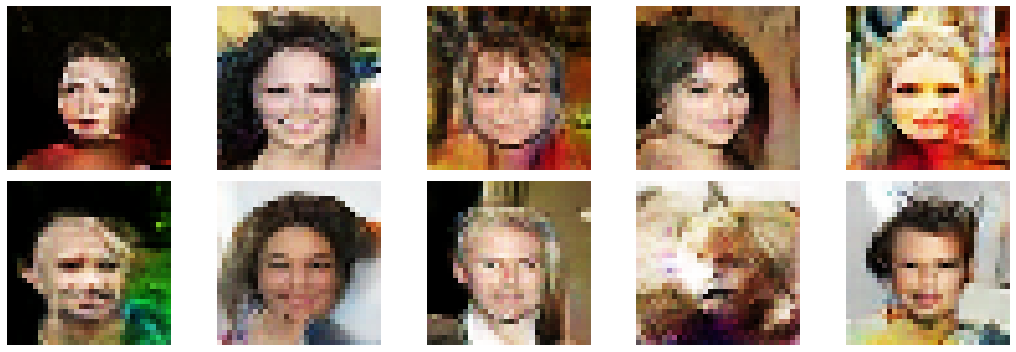

3125/3125 [==============================] - 180s 57ms/step - d_loss: 0.5869 - g_loss: 1.0205
Epoch 78/100
3125/3125 [==============================] - ETA: 0s - d_loss: 0.5836 - g_loss: 1.0287

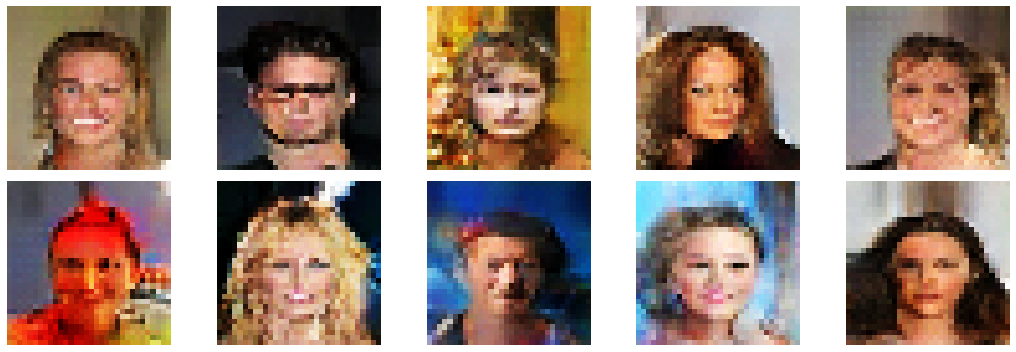

3125/3125 [==============================] - 119s 38ms/step - d_loss: 0.5836 - g_loss: 1.0287
Epoch 79/100
3125/3125 [==============================] - ETA: 0s - d_loss: 0.5832 - g_loss: 1.0292

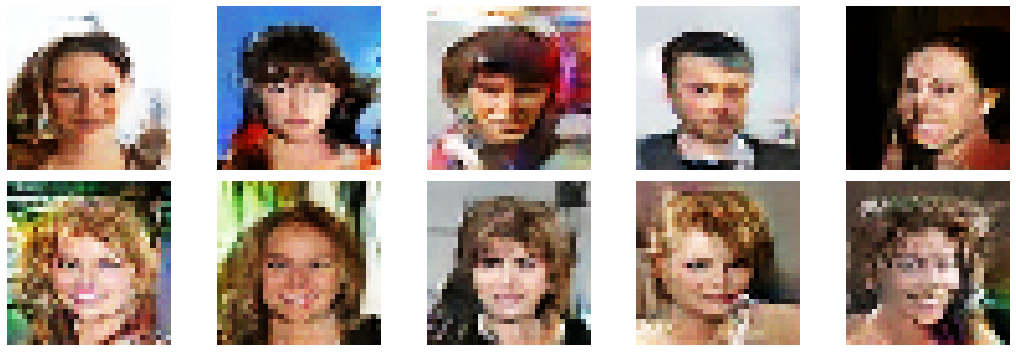

3125/3125 [==============================] - 181s 58ms/step - d_loss: 0.5832 - g_loss: 1.0292
Epoch 80/100
3124/3125 [============================>.] - ETA: 0s - d_loss: 0.5826 - g_loss: 1.0226

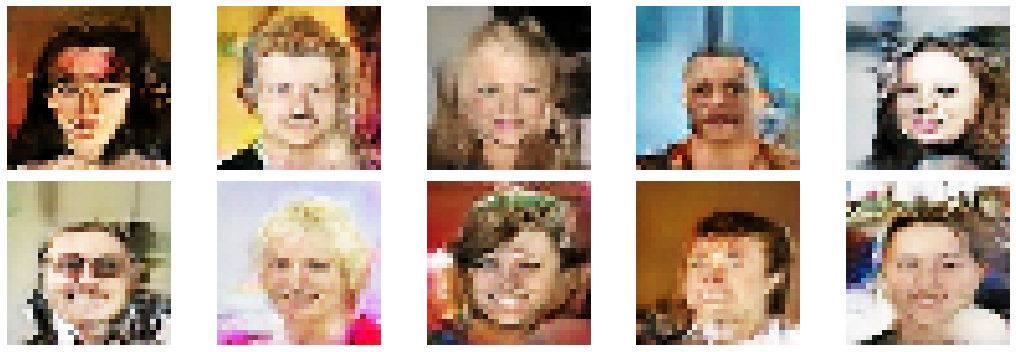

3125/3125 [==============================] - 168s 54ms/step - d_loss: 0.5826 - g_loss: 1.0227
Epoch 81/100
3124/3125 [============================>.] - ETA: 0s - d_loss: 0.5805 - g_loss: 1.0417

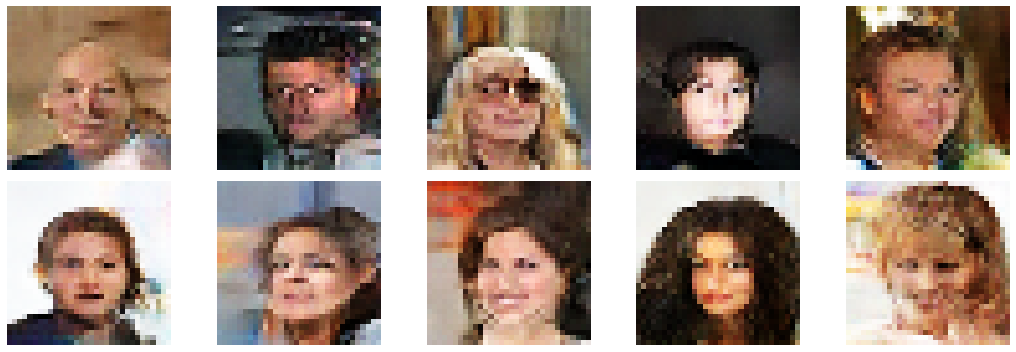

3125/3125 [==============================] - 98s 31ms/step - d_loss: 0.5805 - g_loss: 1.0416
Epoch 82/100
3124/3125 [============================>.] - ETA: 0s - d_loss: 0.5769 - g_loss: 1.0417

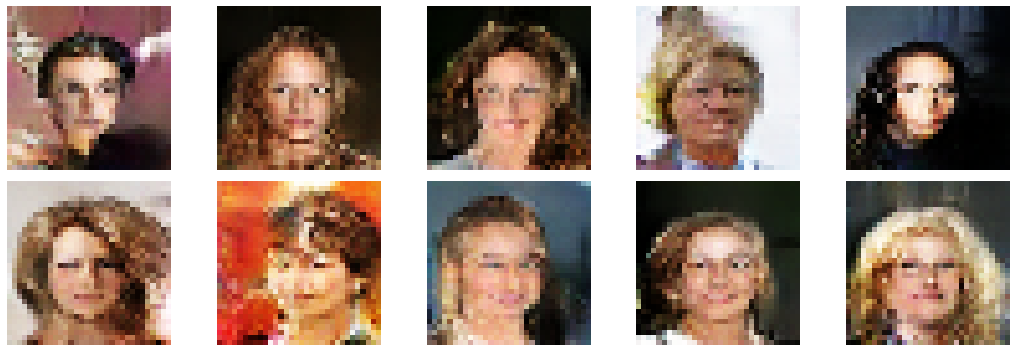

3125/3125 [==============================] - 150s 48ms/step - d_loss: 0.5768 - g_loss: 1.0417
Epoch 83/100
3124/3125 [============================>.] - ETA: 0s - d_loss: 0.5749 - g_loss: 1.0558

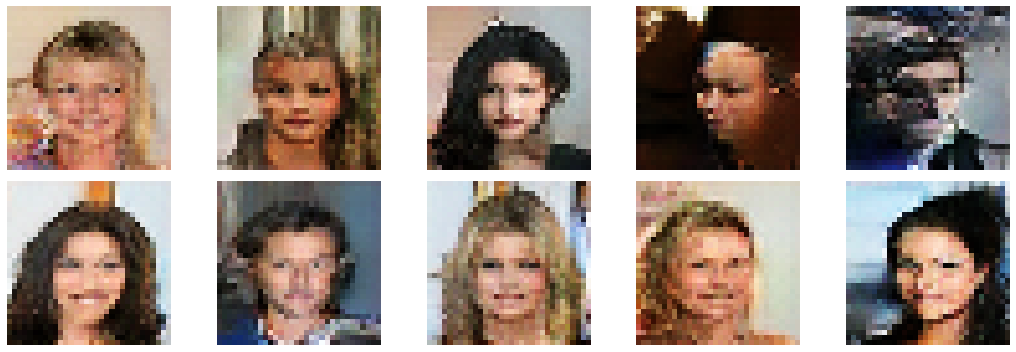

3125/3125 [==============================] - 160s 51ms/step - d_loss: 0.5749 - g_loss: 1.0558
Epoch 84/100
3125/3125 [==============================] - ETA: 0s - d_loss: 0.5754 - g_loss: 1.0512

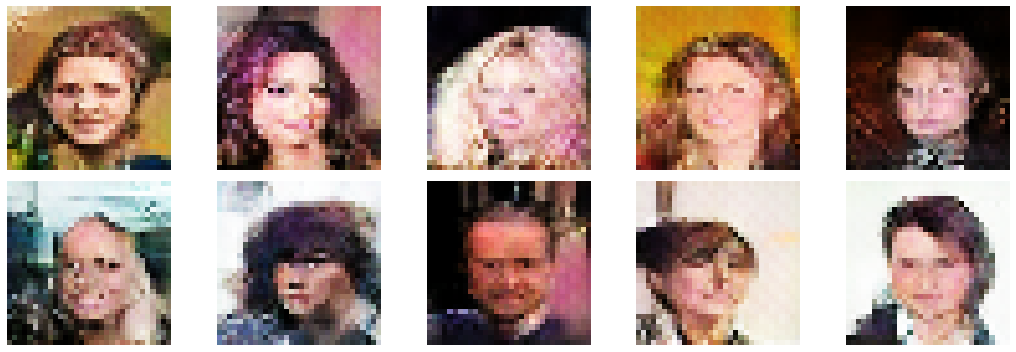

3125/3125 [==============================] - 146s 47ms/step - d_loss: 0.5754 - g_loss: 1.0512
Epoch 85/100
3124/3125 [============================>.] - ETA: 0s - d_loss: 0.5721 - g_loss: 1.0612

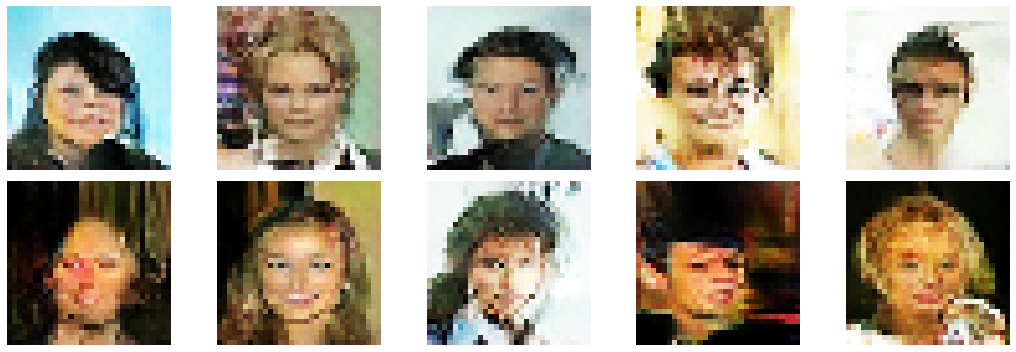

3125/3125 [==============================] - 160s 51ms/step - d_loss: 0.5721 - g_loss: 1.0613
Epoch 86/100
3124/3125 [============================>.] - ETA: 0s - d_loss: 0.5712 - g_loss: 1.0646

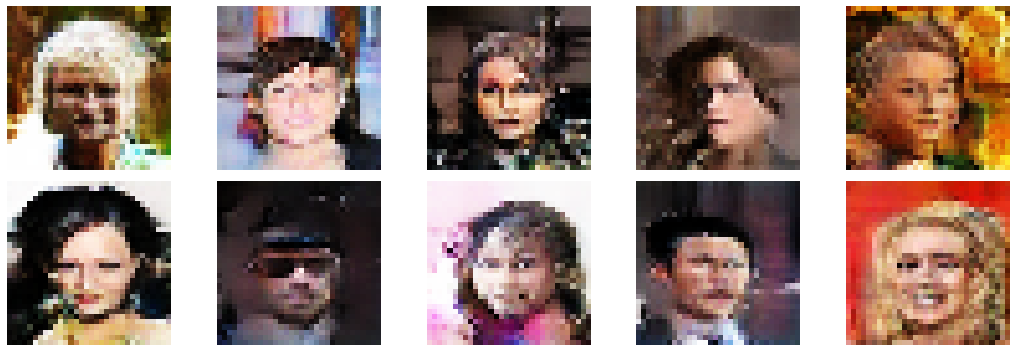

3125/3125 [==============================] - 119s 38ms/step - d_loss: 0.5712 - g_loss: 1.0646
Epoch 87/100
3124/3125 [============================>.] - ETA: 0s - d_loss: 0.5704 - g_loss: 1.0619

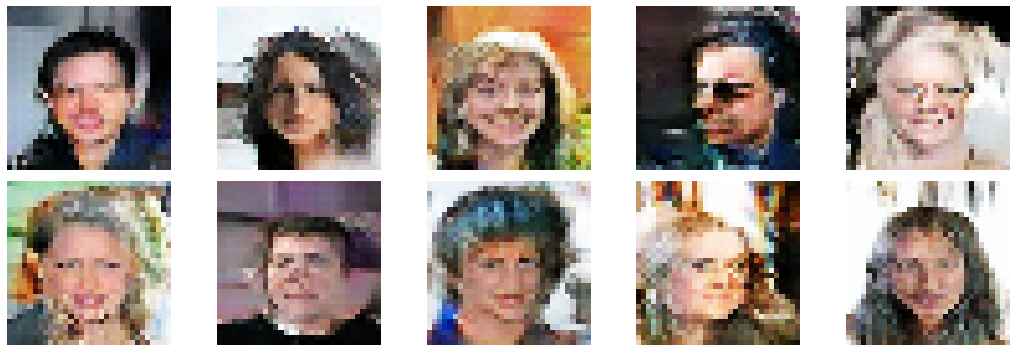

3125/3125 [==============================] - 174s 53ms/step - d_loss: 0.5704 - g_loss: 1.0618
Epoch 88/100
3125/3125 [==============================] - ETA: 0s - d_loss: 0.5702 - g_loss: 1.0709

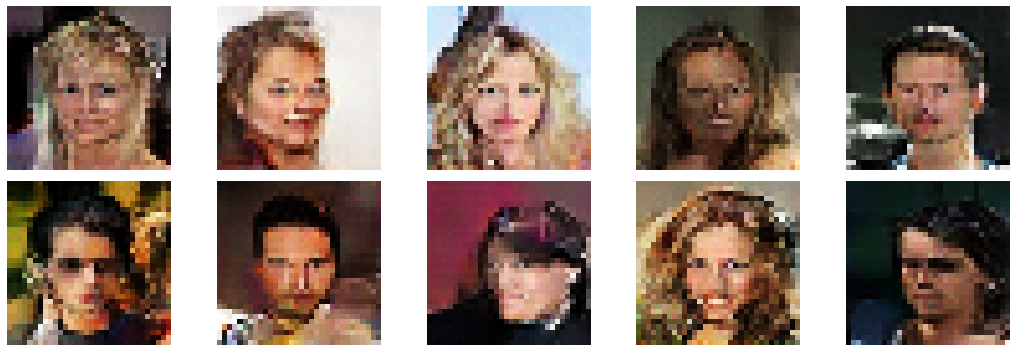

3125/3125 [==============================] - 166s 53ms/step - d_loss: 0.5702 - g_loss: 1.0709
Epoch 89/100
3124/3125 [============================>.] - ETA: 0s - d_loss: 0.5648 - g_loss: 1.0842

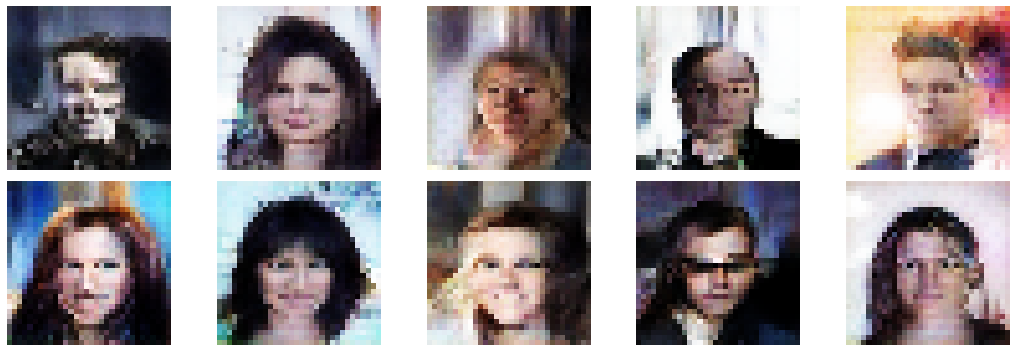

3125/3125 [==============================] - 111s 35ms/step - d_loss: 0.5648 - g_loss: 1.0842
Epoch 90/100
3125/3125 [==============================] - ETA: 0s - d_loss: 0.5696 - g_loss: 1.0731

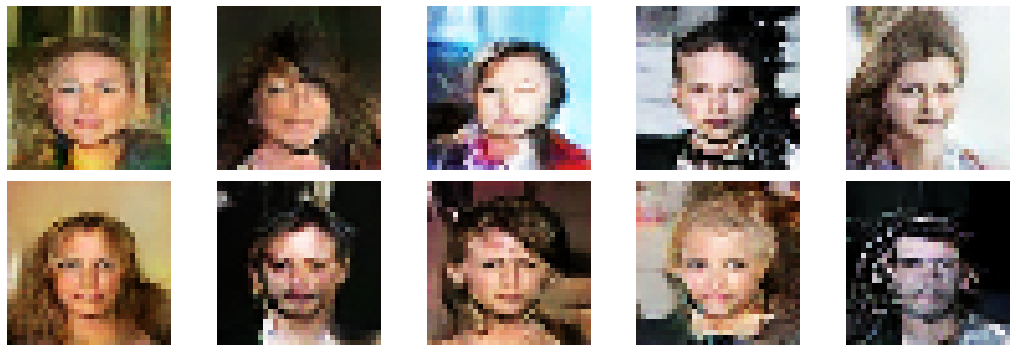

3125/3125 [==============================] - 171s 55ms/step - d_loss: 0.5696 - g_loss: 1.0731
Epoch 91/100
3124/3125 [============================>.] - ETA: 0s - d_loss: 0.5644 - g_loss: 1.0836

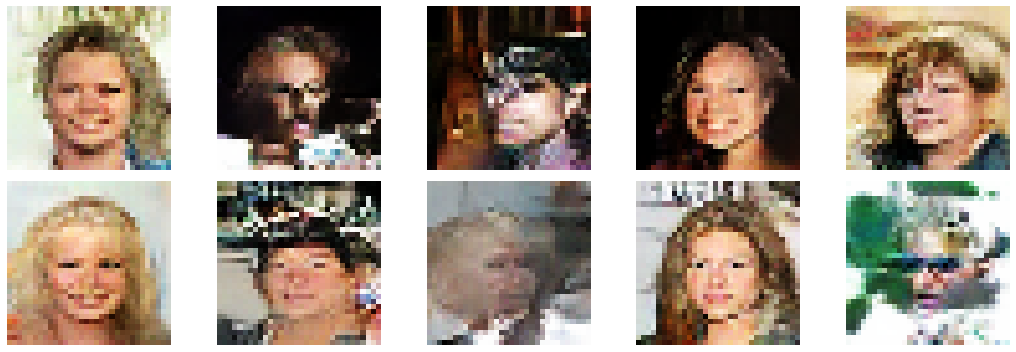

3125/3125 [==============================] - 143s 45ms/step - d_loss: 0.5644 - g_loss: 1.0835
Epoch 92/100
3125/3125 [==============================] - ETA: 0s - d_loss: 0.5611 - g_loss: 1.0968

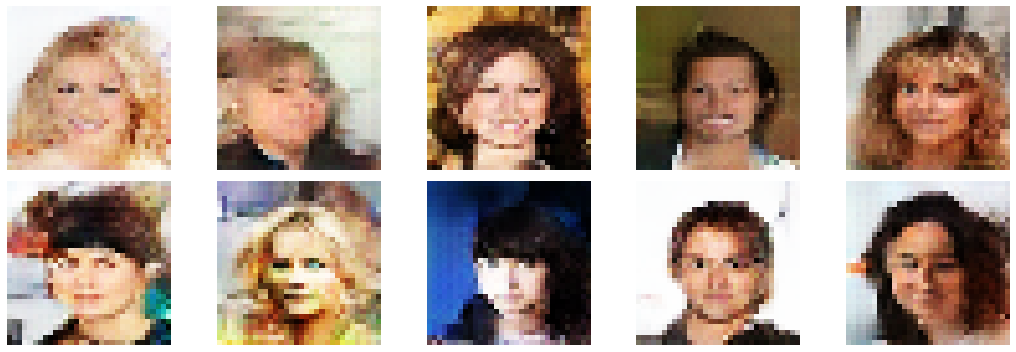

3125/3125 [==============================] - 158s 50ms/step - d_loss: 0.5611 - g_loss: 1.0968
Epoch 93/100
3124/3125 [============================>.] - ETA: 0s - d_loss: 0.5618 - g_loss: 1.0905

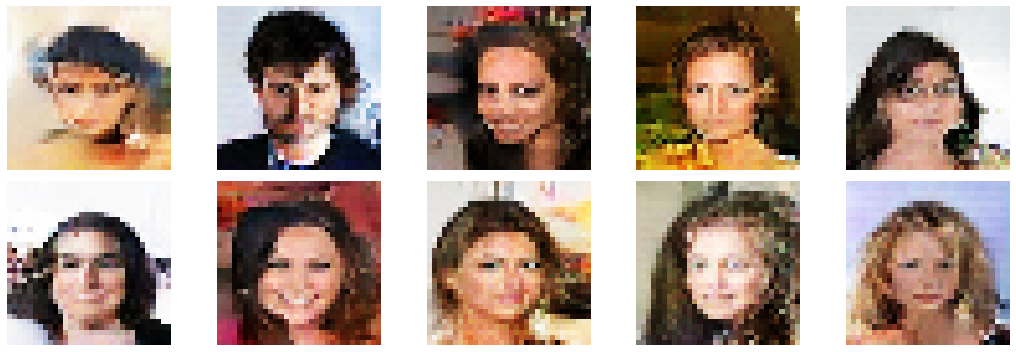

3125/3125 [==============================] - 138s 44ms/step - d_loss: 0.5618 - g_loss: 1.0906
Epoch 94/100
3124/3125 [============================>.] - ETA: 0s - d_loss: 0.5612 - g_loss: 1.0940

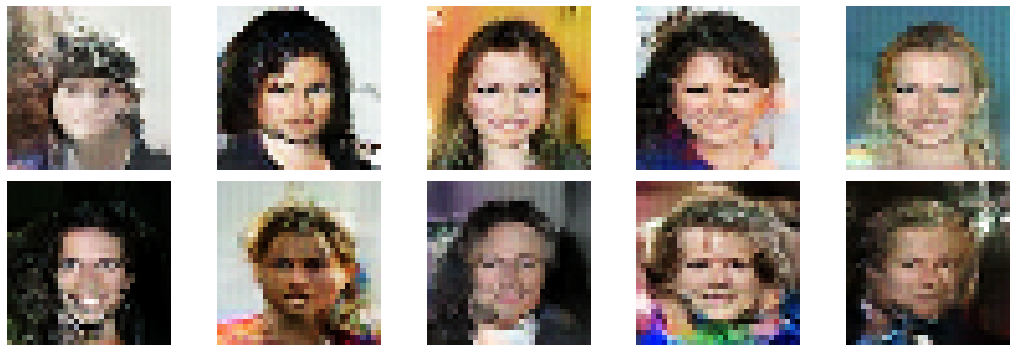

3125/3125 [==============================] - 120s 35ms/step - d_loss: 0.5612 - g_loss: 1.0940
Epoch 95/100
3125/3125 [==============================] - ETA: 0s - d_loss: 0.5606 - g_loss: 1.0977

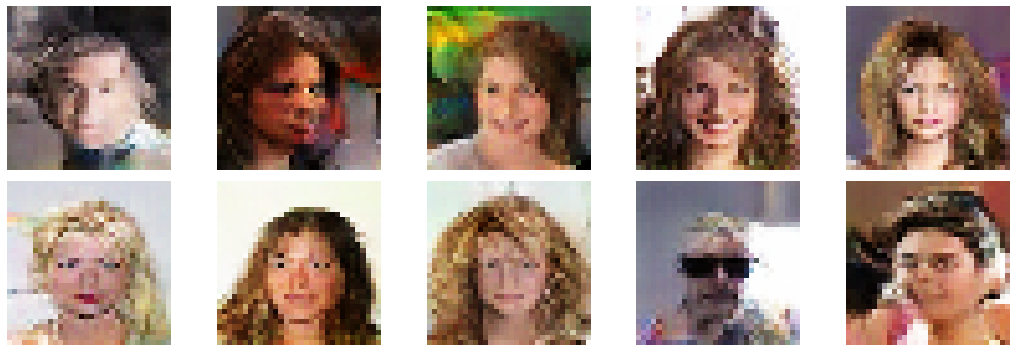

3125/3125 [==============================] - 153s 49ms/step - d_loss: 0.5606 - g_loss: 1.0977
Epoch 96/100
3124/3125 [============================>.] - ETA: 0s - d_loss: 0.5590 - g_loss: 1.1065

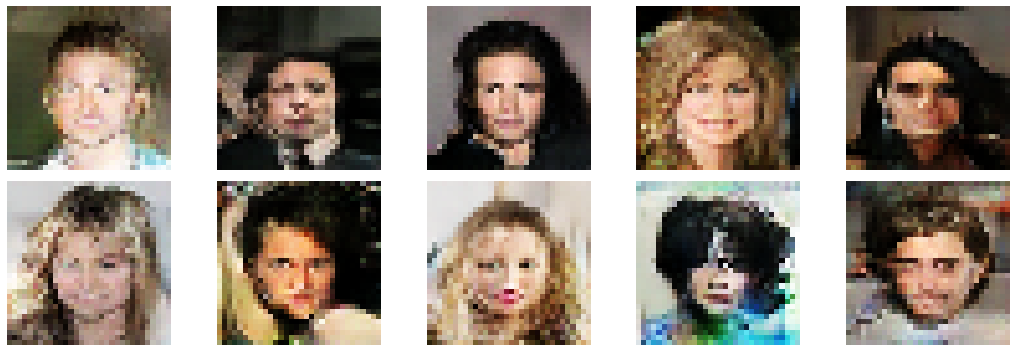

3125/3125 [==============================] - 155s 50ms/step - d_loss: 0.5590 - g_loss: 1.1065
Epoch 97/100
3125/3125 [==============================] - ETA: 0s - d_loss: 0.5580 - g_loss: 1.0977

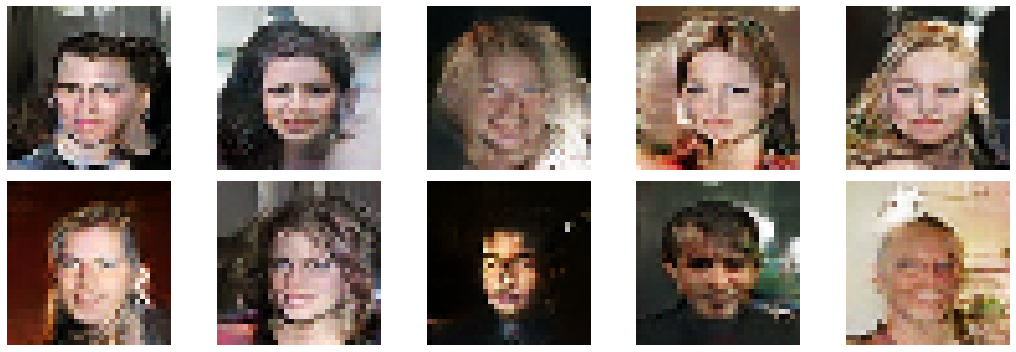

3125/3125 [==============================] - 152s 49ms/step - d_loss: 0.5580 - g_loss: 1.0977
Epoch 98/100
3125/3125 [==============================] - ETA: 0s - d_loss: 0.5538 - g_loss: 1.1173

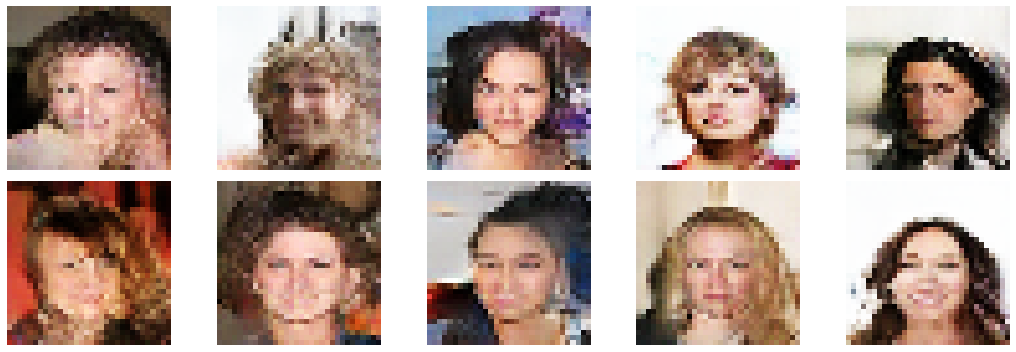

3125/3125 [==============================] - 107s 34ms/step - d_loss: 0.5538 - g_loss: 1.1173
Epoch 99/100
3125/3125 [==============================] - ETA: 0s - d_loss: 0.5543 - g_loss: 1.1196

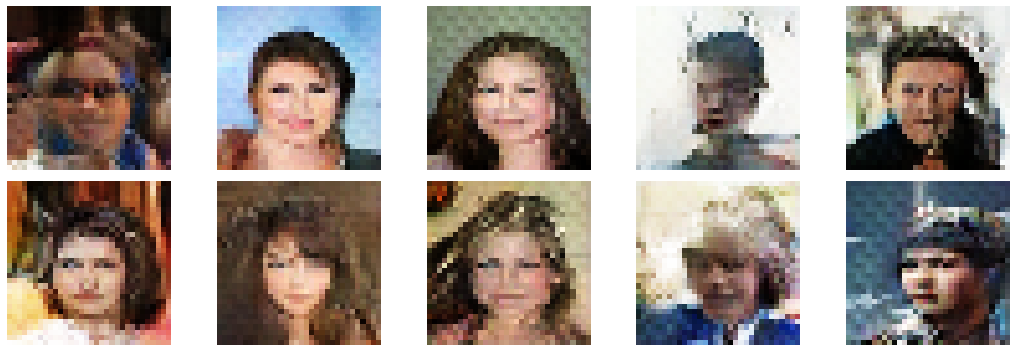

3125/3125 [==============================] - 170s 51ms/step - d_loss: 0.5543 - g_loss: 1.1196
Epoch 100/100
3125/3125 [==============================] - ETA: 0s - d_loss: 0.5549 - g_loss: 1.1117

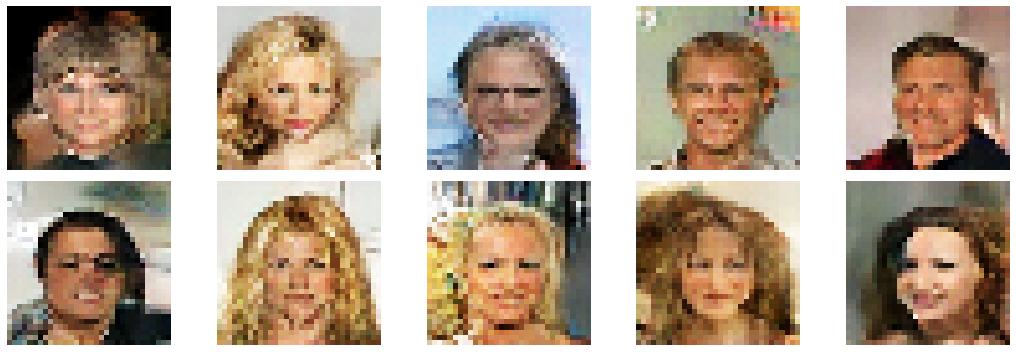

3125/3125 [==============================] - 149s 48ms/step - d_loss: 0.5549 - g_loss: 1.1117


In [ ]:
epochs = 100  # In practice, use ~100 epochs

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

gan.fit(
    dataset, epochs=epochs, callbacks=[GANMonitor(num_img=10, latent_dim=latent_dim)]
)